# Signals Graph Analysis

In [23]:
### header ###
__author__ = "Jenhan Tao"
__license__ = "BSD"
__email__ = "jenhantao@gmail.com"
%load_ext autoreload
%autoreload 2
### imports ###
import sys
%matplotlib inline
import os
import pandas as pd
import numpy as np
import matplotlib
import threading
import multiprocessing
import matplotlib.pyplot as plt 
import seaborn as sns
from collections import Counter
import matplotlib_venn
import networkx as nx
from networkx.drawing.nx_agraph import graphviz_layout
matplotlib.pylab.rcParams['savefig.dpi'] = 200
sys.setrecursionlimit(3000)
import pickle
from sklearn import preprocessing
import time
import scipy
import sklearn
from sklearn import cross_validation
sns.set_context('notebook')
import Bio
from Bio import motifs
from Bio import SeqIO

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
workingDirectory = '/home/jtao/analysis/signals_graph_analysis/'
os.chdir(workingDirectory)

## Functions

In [3]:
def project_database(prefix, database):
    '''
    projects a database of sequences and their corresponding motif paths
    according to a prefix. 
    input: prefix - a string representing a motif and its orientation,
           database - a dictionary containing lists of motif paths
                      corresponding to each sequence
                      {seq_id:[motif_sequences...]}
    output: returns the projected database
    '''
    projected_database = {}
    for seq_id in database:
        projected_paths = []
        motif_paths = database[seq_id]
        for path in motif_paths:
            if prefix in path:
                ind = path.index(prefix)
                proj_path = path[ind+1:]
                if len(proj_path) > 0:
                    projected_paths.append(proj_path)
#         print(prefix, (motif_paths), projected_paths)
        if len(projected_paths) > 0:
            projected_database[seq_id] = projected_paths
        
    return projected_database
def find_frequent_motifs(database, support_level):
    '''
    Finds motifs in database that exceeds support level. 
    For each sequence, collapses the counts of all motif paths corresponding to that sequence
    
    inputs: database - a dictionary containing lists of motif paths
                      corresponding to each sequence
            support_level - number of times a motif must appear to be counted
    outputs: 
    '''
    motif_count_dict = {}
    
    for seq_id in database:
        motifs_in_seq = set()
        motif_paths = database[seq_id]
        for path in motif_paths:
            for motif in path:
                motifs_in_seq.add(motif)
        for m in motifs_in_seq:
            if m in motif_count_dict:
                motif_count_dict[m] += 1
            else:
                motif_count_dict[m] = 1
    
    frequent_motifs = [(x, motif_count_dict[x]) for x in motif_count_dict if motif_count_dict[x] >= support_level]
    sorted_frequent_motifs = sorted(frequent_motifs, key = lambda x:x[1], reverse=True)
    to_return = [x[0] for x in sorted_frequent_motifs]
#     print(len(database), sorted_frequent_motifs[:10])
    return to_return
def motif_prefix_span(prefix, database, support_level):
    '''
    Finds frequents sequences of motifs in a datase of sequences and their corresponding
    motif paths
    inputs: prefix - a string representing a motif and its orientation
            database - a dictionary containing lists of motif paths corresponding to each sequence
            support level - number of times a motif must appear to be counted
    outputs: a list of frequent patterns
    '''
#     print('***', prefix, len(database))
    if len(database) >= support_level:
        frequent_motifs = find_frequent_motifs(database, support_level)
    else:
        frequent_motifs = []
    to_return = []
    if len(frequent_motifs) > 0:
        for fm in frequent_motifs:
            new_pattern = prefix + [fm]
            projected_database = project_database(fm, database)
            
            fm_results = motif_prefix_span(new_pattern, 
                                           projected_database, 
                                           support_level)
            to_return = to_return +  fm_results 

            to_return.append(new_pattern)
    return to_return
# split data into GC content matched training and test data
def get_split(features, labels, test_size):
    '''
    feature: 2D array (samples x features)
    labels: 1D boolean array (samples x)
    test_size: fraction of data to test on
    '''
    
    ### match GC content of samples labelled True with those labelled False by thowing out False samples
    # retrieve sequences using index of labels
    index_label_tuples = tuple(zip(labels.index.values, labels.values))
    
    true_ids = [x[0] for x in index_label_tuples if x[1]]
    
    false_ids = [x[0] for x in index_label_tuples if not x[1]]
       
    filtered_ids = true_ids + false_ids
    filtered_features = features[features.index.isin(filtered_ids)]
    filtered_labels = labels[labels.index.isin(filtered_ids)]

    if test_size <= 0.5:
        training_indices, test_indices = next(iter(
                sklearn.cross_validation.StratifiedKFold(filtered_labels, int(1/test_size), shuffle=True)))
    else:
        test_indices, training_indices = next(
            iter(sklearn.cross_validation.StratifiedKFold(filtered_labels, int(1/(1-test_size)), shuffle=True)))
    training_ids = [filtered_ids[i] for i in training_indices]
    test_ids = [filtered_ids[i] for i in test_indices]
    
    training_features = filtered_features[filtered_features.index.isin(training_ids)]
    test_features = filtered_features[filtered_features.index.isin(test_ids)]
    training_labels = filtered_labels[filtered_labels.index.isin(training_ids)]
    test_labels = filtered_labels[filtered_labels.index.isin(test_ids)]
    
    return training_features, test_features, training_labels, test_labels
def create_pattern_sequence_table(frequent_patterns, 
                                         database):
    '''
    Constructs a matrix summarizing which sequences contains a frequent motif pattern
    '''

    lock = threading.Lock()  
    thread_list = []
    
    has_pattern_dict = {}
    sorted_ids = sorted(database.keys())   

    for i in range(len(frequent_patterns)):
        try:
            pattern = frequent_patterns[i]
            current_thread = threading.Thread(target = find_pattern,
                             args=(pattern,
                                   sorted_ids,
                                   database,
                                   has_pattern_dict,
                                   lock
                                   )      
                            )
            thread_list.append(current_thread)
            current_thread.start()
        finally:
            if lock.locked_lock():
                lock.release()
    for current_thread in thread_list:
        current_thread.join()


    sequence_pattern_table = pd.DataFrame(has_pattern_dict,
                                          index = sorted_ids)
    return sequence_pattern_table
def find_pattern(pattern,
                 sorted_ids,
                 database,
                 result_dict,
                 thread_lock
                 ):
    pattern_name = ' * '.join(pattern)
    has_pattern_list = []
    start = time.time()
    for seq_id in sorted_ids:
        motif_paths = database[seq_id]
        has_pattern = False
        for path in motif_paths:
            path_iter = iter(path)
            has_pattern = all([m in path_iter for m in pattern])
            if has_pattern:
                break
        if has_pattern:
            has_pattern_list.append(1)
        else:
            has_pattern_list.append(0)

    while thread_lock.locked_lock():
        time.sleep(0.05)
    thread_lock.acquire()
    
    result_dict[pattern_name] = has_pattern_list
    print('done searching for', pattern_name, time.time() - start)
    if thread_lock.locked_lock():
        thread_lock.release()



## Peak Merging and Annotation

In [22]:
%%bash
if [ ! -d ./idr_peaks ]; 
    then mkdir ./idr_peaks;
else
    rm ./idr_peaks/*
fi

cp /home/jtao/analysis/signals_analysis/atac_idr_peaks/c57bl6_veh_peaks.tsv ./idr_peaks/
cp /home/jtao/analysis/signals_analysis/atac_idr_peaks/c57bl6_kla-1h_peaks.tsv ./idr_peaks/
cp /home/jtao/analysis/signals_analysis/atac_idr_peaks/c57bl6_ifng-1h_peaks.tsv ./idr_peaks/

In [28]:
%%bash
if [ ! -d ./tag_directories_atac ]; 
    then mkdir ./tag_directories_atac;
else
    rm ./tag_directories_atac/*
fi

for i in /home/jtao/analysis/signals_analysis/tag_directories_atac/*IFNg*;
    do ln -s $i ./tag_directories_atac/;
done

for i in /home/jtao/analysis/signals_analysis/tag_directories_atac/*KLA* ;
    do ln -s $i ./tag_directories_atac/;
done

for i in /home/jtao/analysis/signals_analysis/tag_directories_atac/*Veh*;
    do ln -s $i ./tag_directories_atac/;
done

In [36]:
target_peak_size = 200

if not os.path.isdir('./resized_peak_files'):
    os.mkdir('./resized_peak_files')
else:
    for rpf in os.listdir('./resized_peak_files'):
        os.remove('./resized_peak_files/' + rpf)

for pf in os.listdir('./idr_peaks/'):
    current_peak_frame = pd.read_csv('./idr_peaks/' + pf, sep='\t' )
    peakCenters = (current_peak_frame['start'] + current_peak_frame['end']) /2
    int_peakCenters = np.ceil(peakCenters).astype(int)
    new_starts = int_peakCenters - int(target_peak_size/2)
    new_ends = int_peakCenters + int(target_peak_size/2)
    current_peak_frame['start'] = new_starts
    current_peak_frame['end'] = new_ends
    
    filtered_frame = current_peak_frame.loc[
             ~(current_peak_frame['chr'].str.contains('chrY')) & 
             ~(current_peak_frame['chr'].str.contains('chrM')) &
             ~(current_peak_frame['chr'].str.contains('random')) &
             ~(current_peak_frame['chr'].str.contains('Un'))]
    
    filtered_frame.to_csv('./resized_peak_files/' + pf, sep='\t', index=False)

In [37]:
%%capture
! mergePeaks -d 100 ./resized_peak_files/* > ./merged_atac_peaks.tsv

In [38]:
merged_frame = pd.read_csv('./merged_atac_peaks.tsv', sep='\t')

# filter away peaks in unused chromsomes
filtered_frame = merged_frame.loc[
             ~(merged_frame['chr'].str.contains('chrY')) & 
             ~(merged_frame['chr'].str.contains('chrM')) &
             ~(merged_frame['chr'].str.contains('random')) &
             ~(merged_frame['chr'].str.contains('Un'))]

# resize peaks
target_peak_size = 200
peakCenters = (filtered_frame['start'] + filtered_frame['end']) /2
int_peakCenters = np.ceil(peakCenters).astype(int)
new_starts = int_peakCenters - int(target_peak_size/2)
new_ends = int_peakCenters + int(target_peak_size/2)
filtered_frame.loc[:,'start'] = new_starts
filtered_frame.loc[:,'end'] = new_ends
filtered_frame.to_csv('./merged_atac_peaks_filtered_resized.tsv', sep='\t', index=False)

In [26]:
%%capture
! annotatePeaks.pl ./merged_atac_peaks_filtered_resized.tsv mm10 -d ./tag_directories_atac/ > ./annotated_atac_peaks.tsv



	Peak file = ./merged_atac_peaks_filtered_resized.tsv
	Genome = mm10
	Organism = mouse
	Tag Directories:
		/home/jtao/analysis/signals_analysis/tag_directories_atac/C57Bl6_BMDM_ATAC_IFNg-1h_SD_SD340
		/home/jtao/analysis/signals_analysis/tag_directories_atac/C57Bl6_BMDM_ATAC_IFNg-1h_SD_SD341
		/home/jtao/analysis/signals_analysis/tag_directories_atac/C57Bl6_BMDM_ATAC_KLA-1h_BC_16-02-11-and-16-09-15
		/home/jtao/analysis/signals_analysis/tag_directories_atac/C57Bl6_BMDM_ATAC_KLA-1h_BC_16-05-06
		/home/jtao/analysis/signals_analysis/tag_directories_atac/C57Bl6_BMDM_ATAC_Veh_BC_16-02-11-and-16-09-15
		/home/jtao/analysis/signals_analysis/tag_directories_atac/C57Bl6_BMDM_ATAC_Veh_BC_16-05-06
	Peak/BED file conversion summary:
		BED/Header formatted lines: 0
		peakfile formatted lines: 50181
		Duplicated Peak IDs: 0

	Peak File Statistics:
		Total Peaks: 50181
		Redundant Peak IDs: 0
		Peaks lacking information: 0 (need at least 5 columns per peak)
		Peaks with misformatted coordinates: 0 

## Gene Expression 

In [182]:
%%bash
if [ ! -d ./tag_directories_rna ]; 
    then mkdir ./tag_directories_rna;
else
    rm ./tag_directories_rna/*
fi

for i in /home/jtao/analysis/signals_analysis/tag_directories_rna/*IFNg*;
    do ln -s $i ./tag_directories_rna/;
done

for i in /home/jtao/analysis/signals_analysis/tag_directories_rna/*KLA* ;
    do ln -s $i ./tag_directories_rna/;
done

for i in /home/jtao/analysis/signals_analysis/tag_directories_rna/*Veh*;
    do ln -s $i ./tag_directories_rna/;
done

In [184]:
tag_dirs = sorted(os.listdir('./tag_directories_rna/'))
treated_dirs = ' '.join(['./tag_directories_rna/' + x for x in tag_dirs if not '_Veh-1h_' in x])
veh_dirs = ' '.join(['./tag_directories_rna/' +x for x in tag_dirs if  '_Veh-1h_' in x])

In [186]:
!analyzeRepeats.pl rna mm10 -condenseGenes -count exons -rpkm -d $veh_dirs $treated_dirs > rpkm.tsv

	Tag Directories:
		./tag_directories_rna/C57Bl6_BMDM_RNA_Veh-1h_GJF_16-09-20-rep1
		./tag_directories_rna/C57Bl6_BMDM_RNA_Veh-1h_GJF_16-09-20-rep2
		./tag_directories_rna/C57Bl6_BMDM_RNA_IFNg-1h_GJF_16-09-20-rep1
		./tag_directories_rna/C57Bl6_BMDM_RNA_IFNg-1h_GJF_16-09-20-rep2
		./tag_directories_rna/C57Bl6_BMDM_RNA_KLA-1h_Newton-Josh_14-03-01-rep1
		./tag_directories_rna/C57Bl6_BMDM_RNA_KLA-1h_Newton-Josh_14-03-01-rep2
		./tag_directories_rna/C57Bl6_BMDM_RNA_VehTgfB-1h_GJF_16-09-20-rep2
		./tag_directories_rna/C57Bl6_BMDM_RNA_VehTgfB-1h_GJF_16-09_20-rep1
	Input file format: homerRmsk
	Filtering based on repeat parameters: kept 35756 of 35756
	Calculating read coverage for ./tag_directories_rna/C57Bl6_BMDM_RNA_Veh-1h_GJF_16-09-20-rep1
	Calculating read coverage for ./tag_directories_rna/C57Bl6_BMDM_RNA_Veh-1h_GJF_16-09-20-rep2
	Calculating read coverage for ./tag_directories_rna/C57Bl6_BMDM_RNA_IFNg-1h_GJF_16-09-20-rep1
	Calculating read coverage for ./tag_directories_rna/C57Bl6_BMDM

In [31]:
rpkm_frame = pd.read_csv('./rpkm.tsv', sep='\t')
columns = rpkm_frame.columns.values
columns[0] = 'Refseq'
columns[7] = 'Gene'
rpkm_frame.columns = columns
rpkm_frame['All Gene Names'] = rpkm_frame['Gene'].values
rpkm_frame['Gene'] = [x.split('|')[0] for x in rpkm_frame['Gene'].values]
rpkm_frame.index = rpkm_frame['Gene'].values
# rpkm_frame.drop('chr', axis=1, inplace=True)
# rpkm_frame.drop('start', axis=1, inplace=True)
# rpkm_frame.drop('end', axis=1, inplace=True)
rpkm_frame.drop('strand', axis=1, inplace=True)
rpkm_frame.drop('Length', axis=1, inplace=True)
rpkm_frame.drop('Copies', axis=1, inplace=True)
conditions = set(sorted([x.split('/')[-1].split('_')[3] for x in rpkm_frame.columns if 'tag_directories' in x]))
rpkm_mean_frame = rpkm_frame[['Refseq', 'Gene', 'All Gene Names']]
for condition in conditions:
    current_cols = [x for x in rpkm_frame.columns if condition in x]
    mean_vals = rpkm_frame[current_cols].mean(axis=1)
    rpkm_mean_frame[condition] = mean_vals
    

ERROR! Session/line number was not unique in database. History logging moved to new session 394


/home/jtao/software/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


## Call Differential ATAC Peaks

In [29]:
tag_dirs = sorted(os.listdir('./tag_directories_atac/'))
treated_dirs = ' '.join(['./tag_directories_atac/' + x for x in tag_dirs if not '_Veh_' in x])
veh_dirs = ' '.join(['./tag_directories_atac/' +x for x in tag_dirs if  '_Veh_' in x])

! annotatePeaks.pl ./merged_atac_peaks_filtered_resized.tsv mm10 -raw -d $veh_dirs $treated_dirs > ./annotated_atac_peaks_raw.tsv


	Peak file = ./merged_atac_peaks_filtered_resized.tsv
	Genome = mm10
	Organism = mouse
	Will NOT normalize tag counts
	Tag Directories:
		./tag_directories_atac/C57Bl6_BMDM_ATAC_Veh_BC_16-02-11-and-16-09-15
		./tag_directories_atac/C57Bl6_BMDM_ATAC_Veh_BC_16-05-06
		./tag_directories_atac/C57Bl6_BMDM_ATAC_IFNg-1h_SD_SD340
		./tag_directories_atac/C57Bl6_BMDM_ATAC_IFNg-1h_SD_SD341
		./tag_directories_atac/C57Bl6_BMDM_ATAC_KLA-1h_BC_16-02-11-and-16-09-15
		./tag_directories_atac/C57Bl6_BMDM_ATAC_KLA-1h_BC_16-05-06
	Peak/BED file conversion summary:
		BED/Header formatted lines: 0
		peakfile formatted lines: 50181
		Duplicated Peak IDs: 0

	Peak File Statistics:
		Total Peaks: 50181
		Redundant Peak IDs: 0
		Peaks lacking information: 0 (need at least 5 columns per peak)
		Peaks with misformatted coordinates: 0 (should be integer)
		Peaks with misformatted strand: 0 (should be either +/- or 0/1)

	Peak file looks good!

	Reading Positions...
	-----------------------
	Finding Closest TSS.

In [4]:
# read in annotated frame
annotated_frame = pd.read_csv('./annotated_atac_peaks.tsv', sep='\t')
annotated_frame.index = annotated_frame['Chr'] + ':' + (annotated_frame['Start'] -1).astype(str) + '-' + annotated_frame['End'].astype(str)

# get enhancer associated peaks and associated gene names
annotated_frame['Annotation'] = [x.split(' ')[0] for x in annotated_frame['Annotation'].astype(str)]

columns = list(annotated_frame.columns.values)
columns = columns[:4] + ['Annotation', 'Gene Name'] + [x for x in columns[1:] if 'Tag Count' in x]
annotated_frame = annotated_frame[columns]
columns[0] = 'PeakID'
columns = [x.split('/')[-1].split(' ')[0] if '/' in x else x for x in columns]
annotated_frame.columns = columns

annotated_mean_frame = annotated_frame[[]]

treatments = set([x.split('_')[3] for x in annotated_frame.columns if '_' in x])
print('treatment loop')
for treatment in treatments:
    print(treatment)
    treatment_cols = [x for x in columns if treatment in x]
    annotated_mean_frame[treatment] = annotated_frame[treatment_cols].mean(axis=1).values

enhancer_ids = annotated_frame[annotated_frame['Annotation'].str.contains('Intergenic')].index.values
annotated_enhancer_frame = annotated_mean_frame[annotated_mean_frame.index.isin(enhancer_ids)]

treatment loop
KLA-1h
IFNg-1h
Veh


/home/jtao/software/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [5]:
annotated_enhancer_frame.shape

(16814, 3)

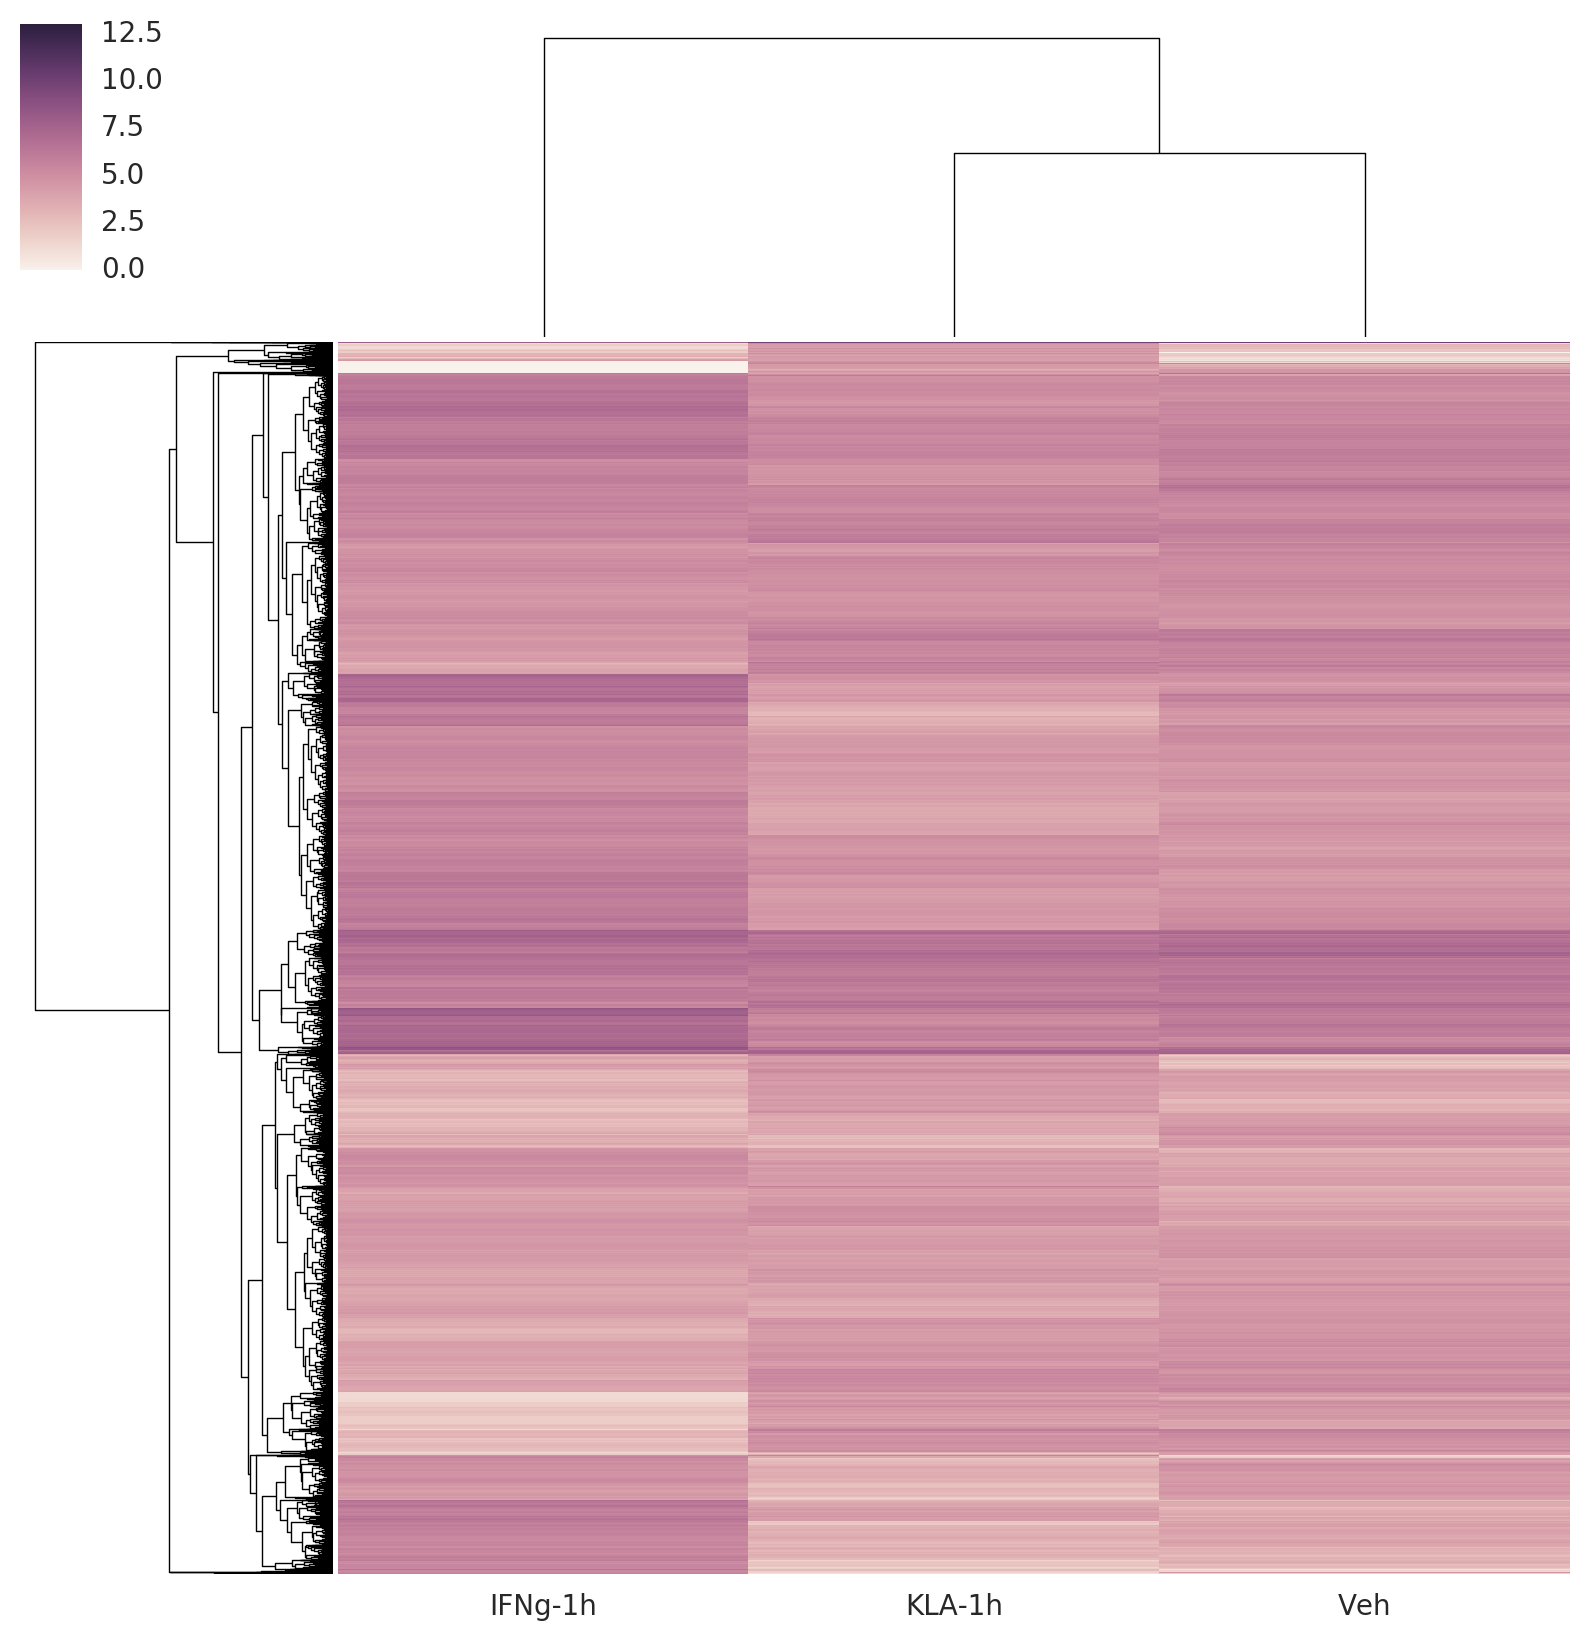

In [6]:
sns.clustermap(np.log2(annotated_enhancer_frame+1),
#                standard_scale=0,
               yticklabels=False)

In [7]:
with open('./annotated_atac_peaks_raw.tsv') as f:
    data = f.readline()
conditions = [x.split('/')[2].split('_')[3] for x in data.split('\t')[19:]]
condition_string = ' '.join(conditions)
!getDiffExpression.pl ./annotated_atac_peaks_raw.tsv $condition_string -AvsA > edgeR_atac_out.tsv


	Differential Expression Program: edgeR
	Autodetecting input file format...
	Using edgeR to calculate differential expression/enrichment...
	Autodetected annotatePeaks.pl file
	Output Stats Veh vs. IFNg-1h:
		Total Genes: 50181
		Total Up-regulated in IFNg-1h vs. Veh: 5163 (10.289%) [log2fold>1, FDR<0.05]
		Total Dn-regulated in IFNg-1h vs. Veh: 5181 (10.325%) [log2fold<-1, FDR<0.05]
	Output Stats Veh vs. KLA-1h:
		Total Genes: 50181
		Total Up-regulated in KLA-1h vs. Veh: 1730 (3.448%) [log2fold>1, FDR<0.05]
		Total Dn-regulated in KLA-1h vs. Veh: 570 (1.136%) [log2fold<-1, FDR<0.05]
	Output Stats IFNg-1h vs. KLA-1h:
		Total Genes: 50181
		Total Up-regulated in KLA-1h vs. IFNg-1h: 8128 (16.197%) [log2fold>1, FDR<0.05]
		Total Dn-regulated in KLA-1h vs. IFNg-1h: 7192 (14.332%) [log2fold<-1, FDR<0.05]



In [8]:
def quantile_normalize_df(df_input):
    df = df_input.copy()
    #compute rank
    dic = {}
    for col in df:
        dic.update({col : sorted(df[col])})
    sorted_df = pd.DataFrame(dic)
    rank = sorted_df.mean(axis = 1).tolist()
    #sort
    for col in df:
        t = np.searchsorted(np.sort(df[col]), df[col])
        df[col] = [rank[i] for i in t]
    return df

In [9]:
edger_frame = pd.read_csv('edgeR_atac_out.tsv', sep='\t')
columns = edger_frame.columns.values
columns[0] = 'PeakID'
edger_frame.columns = columns
edger_frame.index = edger_frame['Chr'] + ':' + (edger_frame['Start'] -1).astype(str) + '-' + edger_frame['End'].astype(str)

In [10]:
differential_peak_ids = edger_frame[edger_frame[[x for x in edger_frame.columns if 'adj. p-value' in x]].min(axis=1) < 0.05].index.values

In [11]:
differential_enhancer_frame = annotated_enhancer_frame.loc[differential_peak_ids,:].dropna()

In [12]:
differential_enhancer_frame.shape

(6923, 3)

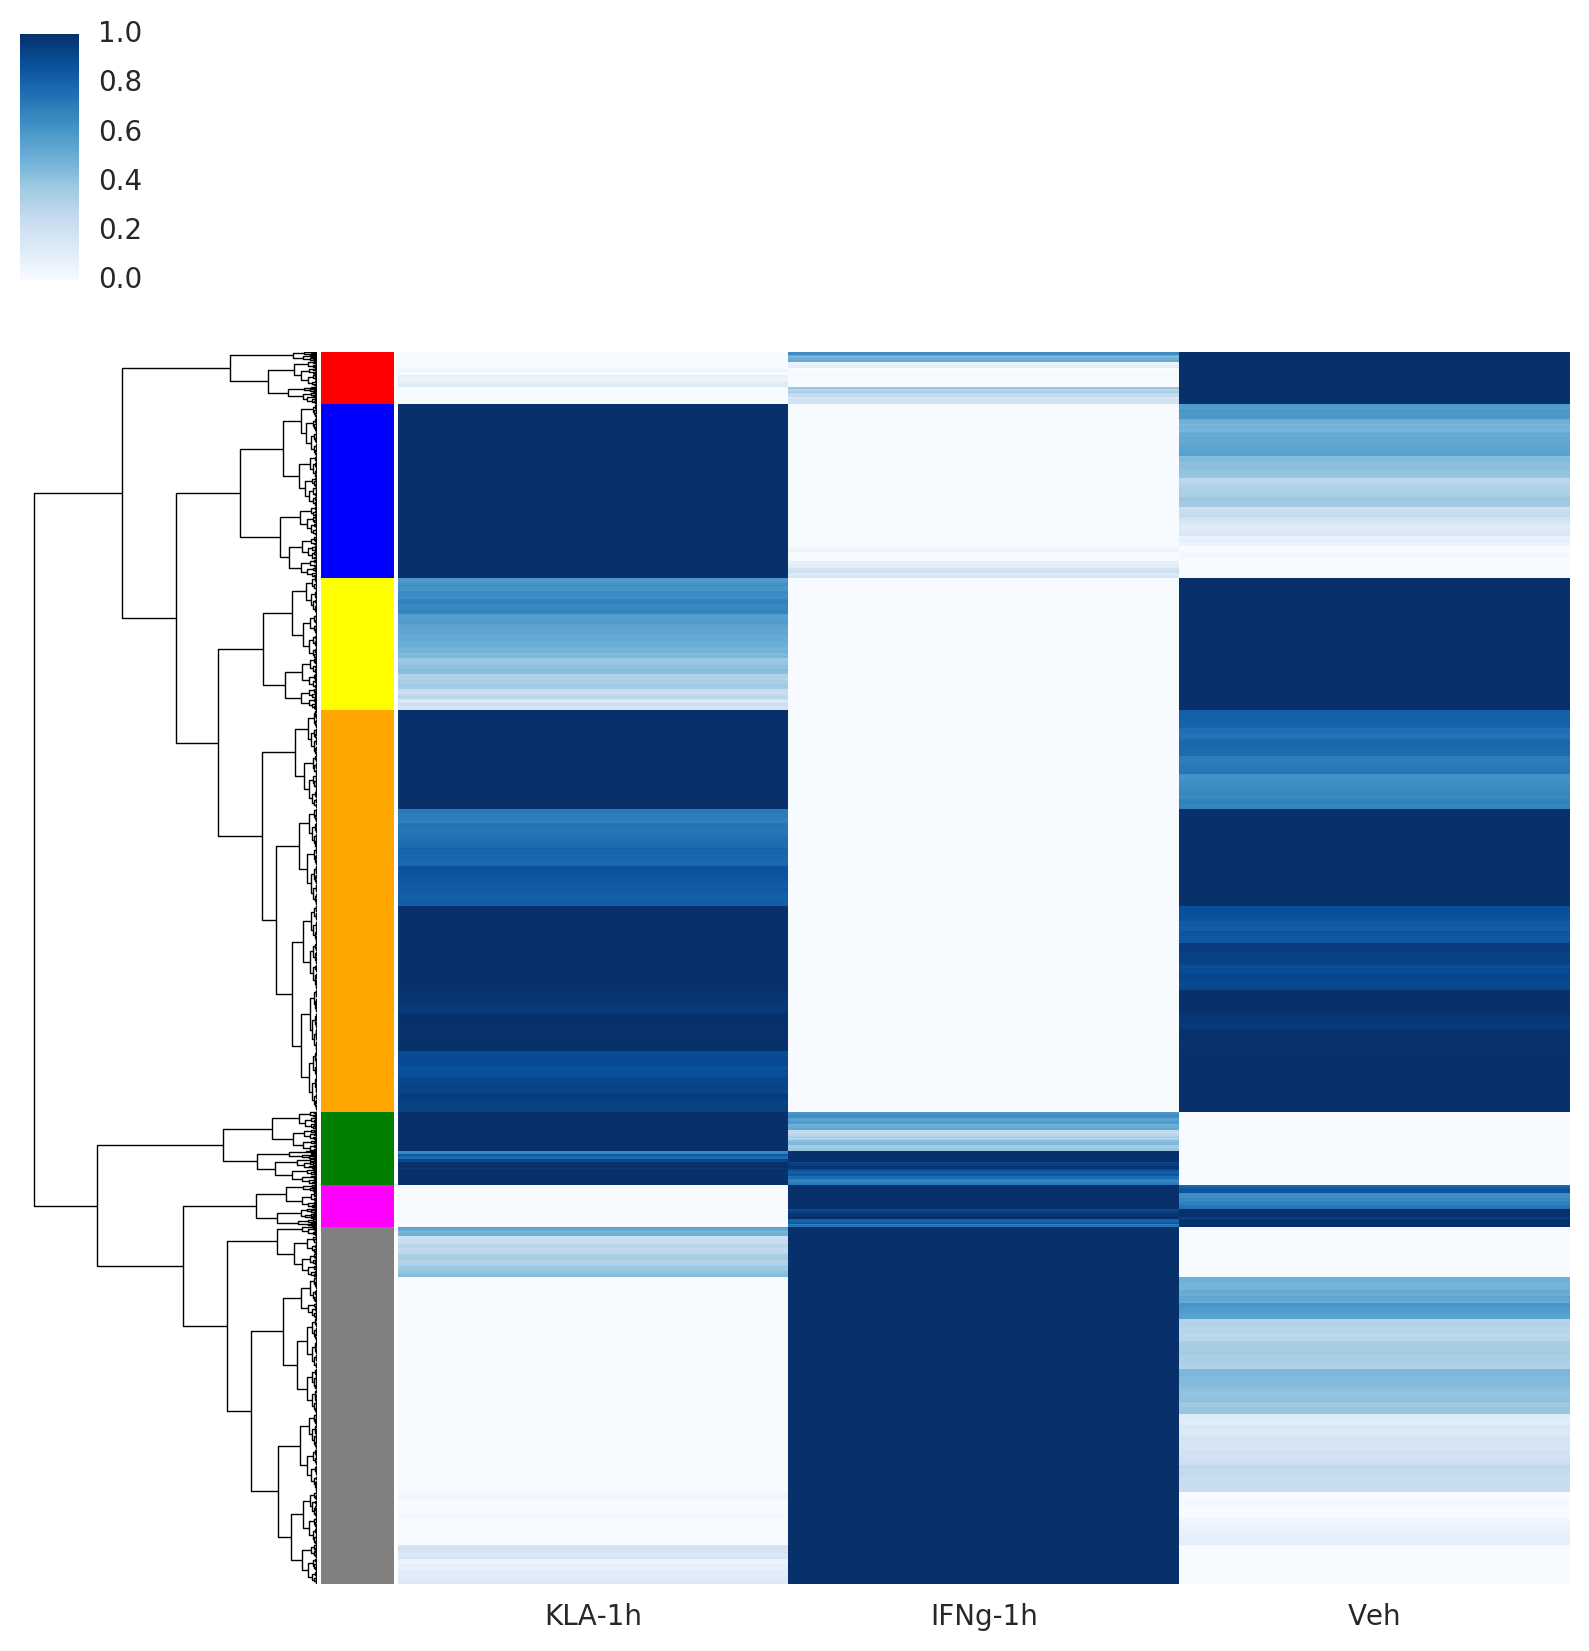

In [13]:
numRowClusters = 7
colorDict = dict(zip(range(numRowClusters),['red', 'blue', 'yellow', 'orange', 'green', 'magenta', 'grey']))


data = np.log2(differential_enhancer_frame[[x for x in differential_enhancer_frame.columns if not x == 'cluster']]+1)

cg = sns.clustermap(data,
               yticklabels=False,
#                metric = 'correlation',
               cmap='Blues',
               standard_scale=0,
#                vmax=8,
              )
plt.close()

row_linkage = cg.dendrogram_row.linkage

row_flatCluster = scipy.cluster.hierarchy.fcluster(row_linkage, numRowClusters, criterion="maxclust")

row_colors = [colorDict[row_flatCluster[i] -1] for i in range(len(data.index))]
sns.clustermap(data, 
                row_linkage = row_linkage,
                row_colors = row_colors,
                yticklabels = False,
                col_cluster=False,
                cmap='Blues',
               standard_scale=0,
)
differential_enhancer_frame['cluster'] = row_flatCluster

## Train TBA Models

In [49]:
%%bash 
if [ ! -d ./bed_files ];
    then mkdir ./bed_files
    else rm ./bed_files/*
fi

for f in ./resized_peak_files/*;
do pos2bed.pl $f >./tmp;
    outpath=${f/.tsv/.bed}
    outpath=${outpath/resized_peak_files/bed_files}
    tail -n +2 ./tmp> $outpath
done
rm ./tmp


	Converted 27146 peaks total


	Converted 34201 peaks total


	Converted 35327 peaks total



In [51]:
%%bash
if [ ! -d ./fasta_files ];
    then mkdir ./fasta_files
    else rm ./fasta_files/*
fi

for f in ./bed_files/*;
do outpath=${f/.bed/.fa}
    outpath=${outpath/bed_files/fasta_files}
    /home/jtao/code/tba/model_training/extract_sequences.py $f mm10  $outpath
done

reading genome mm10
reading genome mm10
reading genome mm10


rm: cannot remove ‘./fasta_files/*’: No such file or directory


### Construct Background

In [128]:
%%bash
rm ./make_background.sh
script_path="./make_background.sh"
if [ ! -d ./background/ ]; then mkdir ./background/ ; fi
for i in ./bed_files/*bed;
do 
    factor=${i##*/};
    factor=${factor%_peaks.bed};
    fasta_path="./background/${factor}_background.fa"
    bed_path="./background/${factor}_background.bed"

    echo "/home/jtao/code/tba/model_training/generate_background_coordinates.py $i ./background/ -genome mm10";
    echo "mv ./background/background.bed $bed_path";
    echo "mv ./background/background.fasta $fasta_path";
    echo "/home/jtao/code/tba/model_training/generate_background_coordinates.py $i ./background/ -genome mm10" >> $script_path;
    echo "mv ./background/background.bed $bed_path" >> $script_path;
    echo "mv ./background/background.fasta $fasta_path" >> $script_path;
done

/home/jtao/code/tba/model_training/generate_background_coordinates.py ./bed_files/c57bl6_ifng-1h_peaks.bed ./background/ -genome mm10
mv ./background/background.bed ./background/c57bl6_ifng-1h_background.bed
mv ./background/background.fasta ./background/c57bl6_ifng-1h_background.fa
/home/jtao/code/tba/model_training/generate_background_coordinates.py ./bed_files/c57bl6_kla-1h_peaks.bed ./background/ -genome mm10
mv ./background/background.bed ./background/c57bl6_kla-1h_background.bed
mv ./background/background.fasta ./background/c57bl6_kla-1h_background.fa
/home/jtao/code/tba/model_training/generate_background_coordinates.py ./bed_files/c57bl6_veh_peaks.bed ./background/ -genome mm10
mv ./background/background.bed ./background/c57bl6_veh_background.bed
mv ./background/background.fasta ./background/c57bl6_veh_background.fa


In [55]:
%%bash
rm ./background/*
chmod a+x ./*sh
bash ./make_background.sh   

reading genome mm10
done reading genome
0 0
target GC: 0.4296456154502597 background GC: 0.42744014732957214 target length: 201 numTargetPositions 2715 backgroundPositions 2715
0 0
target GC: 0.47159607641423157 background GC: 0.4664460368687952 target length: 201 numTargetPositions 2715 backgroundPositions 2715
0 0
target GC: 0.4950552037134395 background GC: 0.48849078277984637 target length: 201 numTargetPositions 2715 backgroundPositions 2715
0 0
target GC: 0.5157363246866359 background GC: 0.507955436427528 target length: 201 numTargetPositions 2715 backgroundPositions 2715
0 0
target GC: 0.5365585449257314 background GC: 0.5291942453912934 target length: 201 numTargetPositions 2715 backgroundPositions 2715
0 0
target GC: 0.5595027515273079 background GC: 0.5490181062304125 target length: 201 numTargetPositions 2715 backgroundPositions 2715
0 0
target GC: 0.5916439190114425 background GC: 0.5817451863092397 target length: 201 numTargetPositions 2714 backgroundPositions 2714
0 0
ta

rm: cannot remove ‘./background/*’: No such file or directory


### Create Features

             

In [212]:
%%bash
positive_seq_dir="./fasta_files/"
negative_seq_dir="./background/"
out_dir="./tba_output/"
script_path='./calculate_features.sh'
motif_dir='/home/jtao/analysis/jaspar_analysis/curated_motifs_jasparFormat/'
if [ -f $script_path ]; then rm $script_path; else touch $script_path; fi
if [ ! -d $out_dir ]; then mkdir $out_dir; fi

for positive_seq_path in $positive_seq_dir/*;
    do factor=${positive_seq_path##./*/};
    factor=${factor%.fa};

    negative_seq_path=${negative_seq_dir}/${factor}_background.fa;
    echo "python /home/jtao/code/tba/model_training/create_features.py $positive_seq_path $negative_seq_path $out_dir ${motif_dir}/*jaspar -num_proc 28 -pseudocount 250" >>$script_path

done

In [62]:
%%bash
rm ./tba_output/*motif_scores*
rm ./tba_output/*motif_starts*
chmod a+x ./*sh
bash ./calculate_features.sh

Arntl calculation time: 5.436504602432251
Gfi1 calculation time: 5.550839185714722
Mafb calculation time: 5.824788808822632
RORA calculation time: 5.465012550354004
TBP calculation time: 7.48396372795105
ascl2_nhlh1_merged calculation time: 5.954046249389648
mef2a_mef2b_mef2d_merged calculation time: 7.381188154220581
CENPB calculation time: 7.916005611419678
Lhx3 calculation time: 6.199098587036133
Nr5a2 calculation time: 7.37024188041687
Sox2 calculation time: 4.644422769546509
ZEB1 calculation time: 5.587018728256226
dbp_hlf_tef_merged calculation time: 7.005045175552368
pou3f4_pou5f1b_merged calculation time: 5.5867087841033936
CTCF calculation time: 8.952112674713135
MYBL1 calculation time: 6.481336832046509
PPARG calculation time: 9.110132217407227
XBP1 calculation time: 7.8597636222839355
esrr calculation time: 5.875525712966919
otx1_otx2_pitx1_pitx3_rhoxf1_merged calculation time: 5.047373533248901
Dmbx1 calculation time: 7.987287521362305
MTF1 calculation time: 6.9653129577636

### Train Models

In [219]:
%%bash
feature_dir="./tba_output/"
out_dir="./tba_output/"
script_path='./train_classifier.sh'
iterations="5"
test_fraction="0.2"
if [ -f $script_path ]; then rm $script_path; else touch $script_path; fi
if [ ! -d $out_dir ]; then mkdir $out_dir; fi

for feature_path in $feature_dir/*combined_features.tsv;
    do factor=${feature_path##./*/};
    factor=${factor%_*_*};
    label_path=${feature_path/combined_features/labels};
    label_path=${label_path/tsv/txt};
    echo "python /home/jtao/code/tba/model_training/train_classifier.py $feature_path $label_path $out_dir -test_fraction $test_fraction -num_iterations $iterations" >>$script_path
    echo "mv $out_dir/performance.tsv $out_dir/${factor}_performance.tsv" >> $script_path
    echo "mv $out_dir/coefficients.tsv $out_dir/${factor}_coefficients.tsv" >> $script_path
done

In [64]:
%%bash
rm ./tba_output/*coefficients*
rm ./tba_output/*performance*
chmod a+x ./*sh
bash ./train_classifier.sh

reading features and labels
training classifier for ./tba_output//c57bl6_ifng-1h_peaks_combined_features.tsv
training iteration: 1
iteration training time: 101.54420948028564 ROC 0.866180790845
training iteration: 2
iteration training time: 100.5334734916687 ROC 0.868552886393
training iteration: 3
iteration training time: 101.05180191993713 ROC 0.86920678042
training iteration: 4
iteration training time: 100.46946597099304 ROC 0.865658743967
training iteration: 5
iteration training time: 102.16368651390076 ROC 0.86809495708
Total time: 505.76290798187256
writing results
reading features and labels
training classifier for ./tba_output//c57bl6_kla-1h_peaks_combined_features.tsv
training iteration: 1
iteration training time: 143.89029812812805 ROC 0.876211752057
training iteration: 2
iteration training time: 147.87281203269958 ROC 0.877544422103
training iteration: 3
iteration training time: 145.0094919204712 ROC 0.877290785728
training iteration: 4
iteration training time: 145.557976961

/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5

### Likelihood Ratio Test

In [220]:
%%bash
feature_dir="./tba_output/"
out_dir="./tba_output/"
script_path='./test_significance.sh'
iterations="5"
test_fraction="0.2"
if [ -f $script_path ]; then rm $script_path; else touch $script_path; fi
if [ ! -d $out_dir ]; then mkdir $out_dir; fi

for feature_path in $feature_dir/*combined_features.tsv;
    do factor=${feature_path##./*/};
    factor=${factor%_*_*};
    label_path=${feature_path/combined_features/labels};
    label_path=${label_path/tsv/txt};
    outpath=${feature_path/combined_features/significance}
    echo "python /home/jtao/code/tba/model_training/calc_feature_significance.py $feature_path $label_path $out_dir -test_fraction $test_fraction -num_iterations $iterations" >>$script_path
    echo "mv $out_dir/significance.tsv $out_dir/${factor}_significance.tsv" >> $script_path
done

In [ ]:
%%bash
rm ./tba_output/*significance*

chmod a+x ./*sh
bash ./test_significance.sh

### Read in Performances

In [132]:
sample_performance_dict = {}
for f in os.listdir('./tba_output/'):
    if 'perf' in f:
        frame = pd.read_csv('./tba_output/' + f, sep='\t')
        mean_roc = np.mean(frame['ROC'])
        sample_performance_dict[f.replace('_performance.tsv','')] = mean_roc

sample_performance_dict

{'c57bl6_ifng-1h': 0.8675388317409929,
 'c57bl6_kla-1h': 0.8776362483004814,
 'c57bl6_veh': 0.8831539296026492}

## Filter Motifs

### Using TBA Values

In [154]:
motif_pval_frame = None
motif_weight_frame = None
for f in os.listdir('./tba_output/'):
    condition = '_'.join(f.split('_')[:2])
    if 'significance' in f:
        print(f)
        # read pvals
        frame = pd.read_csv('./tba_output/' + f, sep='\t', index_col=0)
        mean_pvals = frame.mean(axis=1).values
        if motif_pval_frame is None:
            motif_pval_frame = frame[[]]
        motif_pval_frame.loc[:,condition] = mean_pvals
    elif 'coeff' in f:
        print(f)
        # read weights
        frame = pd.read_csv('./tba_output/' + f, sep='\t', index_col=0)
        mean_pvals = frame.mean(axis=1).values
        if motif_weight_frame is None:
            motif_weight_frame = frame[[]]
        motif_weight_frame.loc[:,condition] = mean_pvals

c57bl6_kla-1h_coefficients.tsv
c57bl6_veh_coefficients.tsv
c57bl6_kla-1h_significance.tsv
c57bl6_veh_significance.tsv
c57bl6_ifng-1h_significance.tsv
c57bl6_ifng-1h_coefficients.tsv


/home/jtao/software/anaconda3/lib/python3.5/site-packages/pandas/core/indexing.py:337: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/home/jtao/software/anaconda3/lib/python3.5/site-packages/pandas/core/indexing.py:601: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item_labels[indexer[info_axis]]] = value


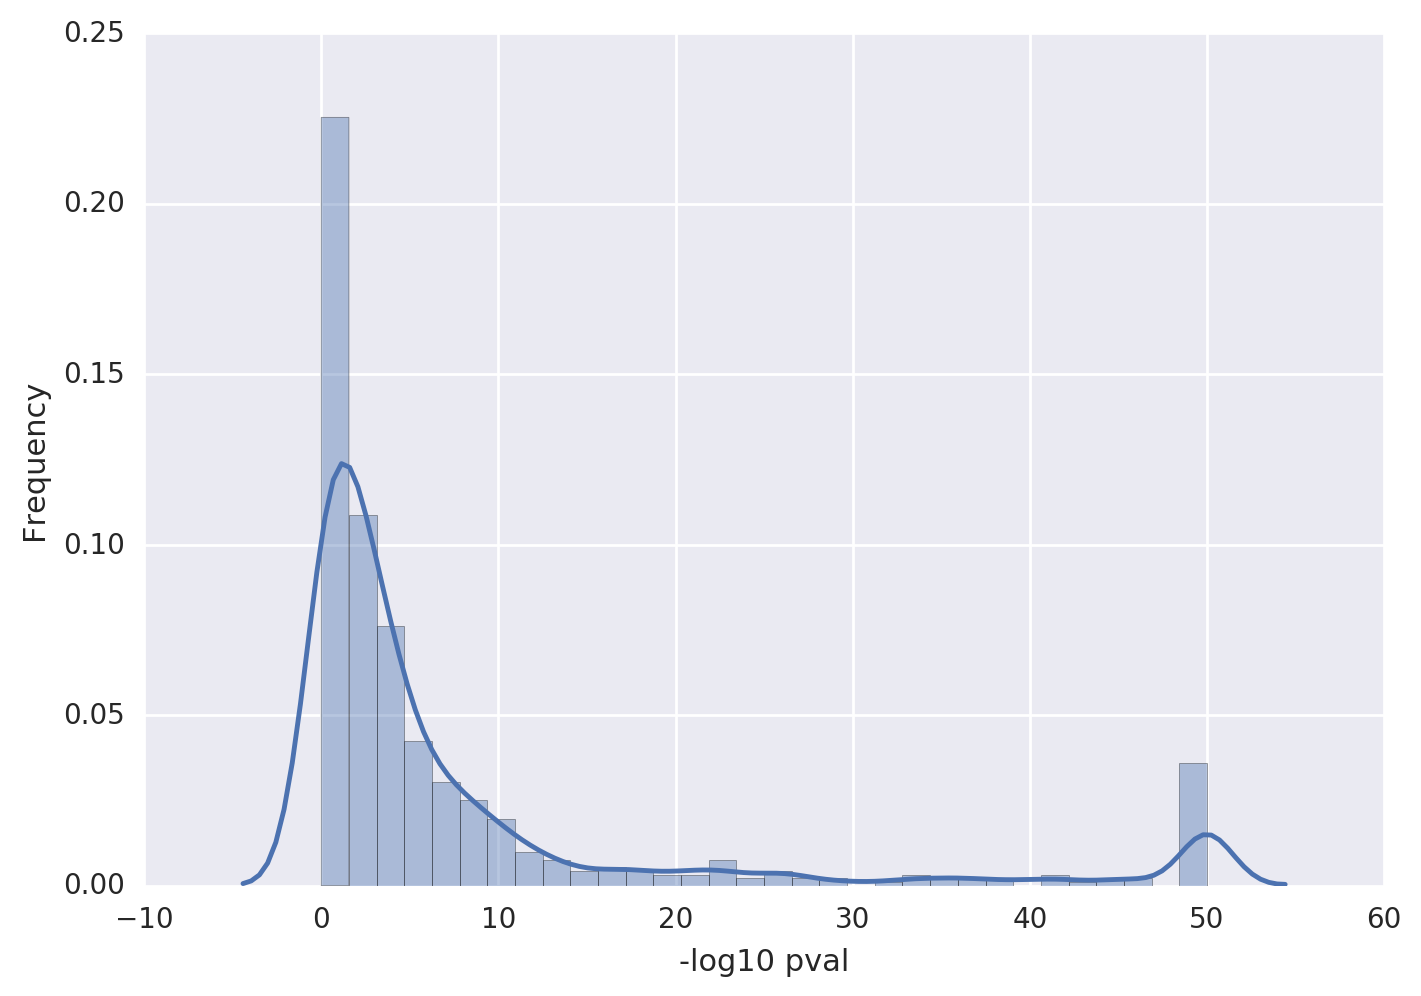

In [167]:
sns.distplot(-np.log10(motif_pval_frame.values.flatten()+1e-50))
plt.ylabel('Frequency')
plt.xlabel('-log10 pval')

In [213]:
motif_pval_frame[motif_pval_frame.min(axis=1) < 10**(-10)].shape

(50, 3)

In [214]:
significant_motifs = motif_pval_frame[motif_pval_frame.min(axis=1) < 10**(-10)].index.values

In [215]:
positive_motifs = motif_weight_frame[motif_weight_frame.max(axis=1) > 0].index.values

In [216]:
tba_motifs = sorted(set(significant_motifs).intersection(set(positive_motifs)))

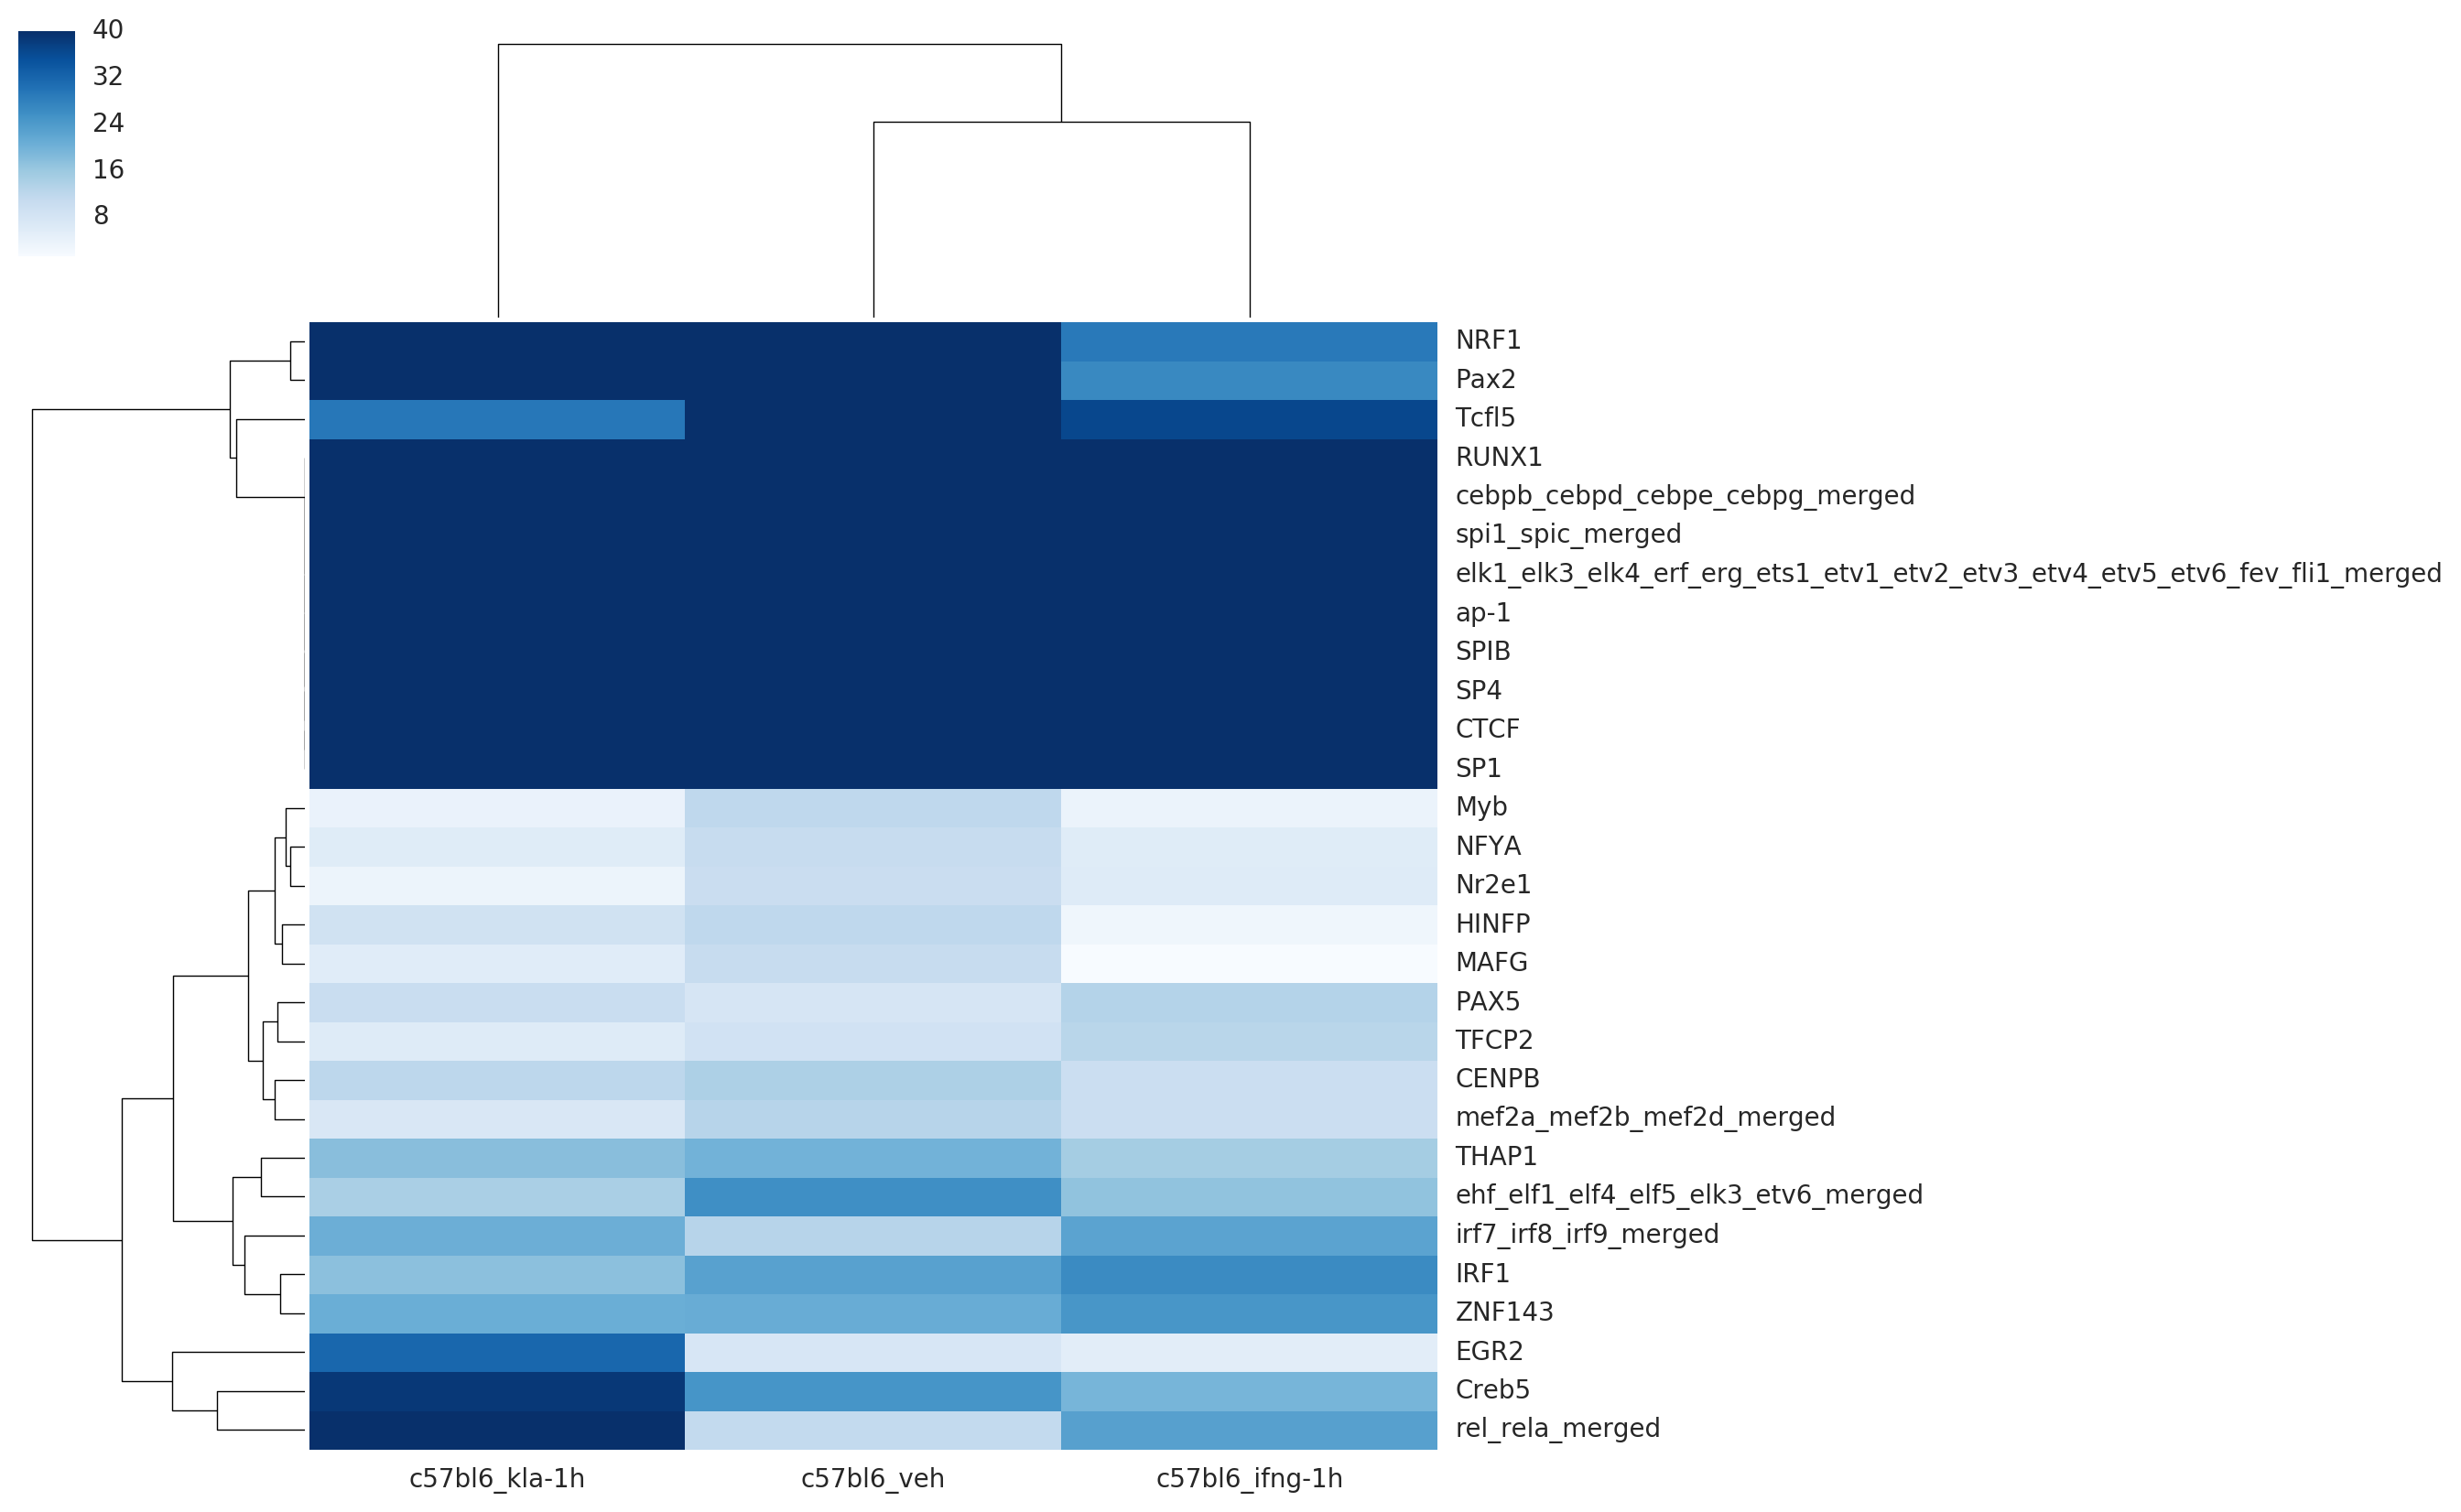

In [273]:
cg = sns.clustermap(-np.log10(motif_pval_frame.loc[tba_motifs]+1e-40),
                    cmap='Blues'
                   )
plt.setp(cg.ax_heatmap.yaxis.get_majorticklabels(), rotation=0);


### Using Expression

### Read in Motifs

In [28]:
def read_jaspar_motif_file(motifPath, pseudocount):
    '''
    reads jaspar motif file
    inputs: path to a jaspar motif file
    outputs: a tuple representing a motif
    '''
    with open(motifPath) as f:
        m = motifs.read(f, 'jaspar')
        default_pseudocount = motifs.jaspar.calculate_pseudocounts(m)
        scaled_pseudocount = pseudocount/0.01 * default_pseudocount['A']
        m.pseudocounts = int(scaled_pseudocount)
    return (m.name, m)

ERROR! Session/line number was not unique in database. History logging moved to new session 393


In [29]:
pseudocount = 0.025
motif_file_path = '/gpfs/data01/glasslab/home/jtao/analysis/jaspar_analysis/curated_motifs_jasparFormat//'
all_motifs = []

for m in os.listdir(motif_file_path):
    if '.jaspar' in m:
        motif = read_jaspar_motif_file(motif_file_path + '/' + m, pseudocount)
        all_motifs.append(motif)
# sort motifs by name
all_motifs.sort(key=lambda x:x[0])
motif_names = [x[0] for x in all_motifs]

In [30]:
gene_motif_dict = {}
with open('/gpfs/data01/glasslab/home/jtao/analysis/jaspar_analysis/clustered_motifs/motifGene.txt') as f:
    data = f.readlines()
for line in data:
    tokens = line.strip().split()
    motif = tokens[0]
    genes = tokens[1].split('|')
    if motif in motif_names:
        for g in genes:
            if g in gene_motif_dict:
                gene_motif_dict[g.upper()].append(motif)
            else:
                gene_motif_dict[g.upper()] = [motif]

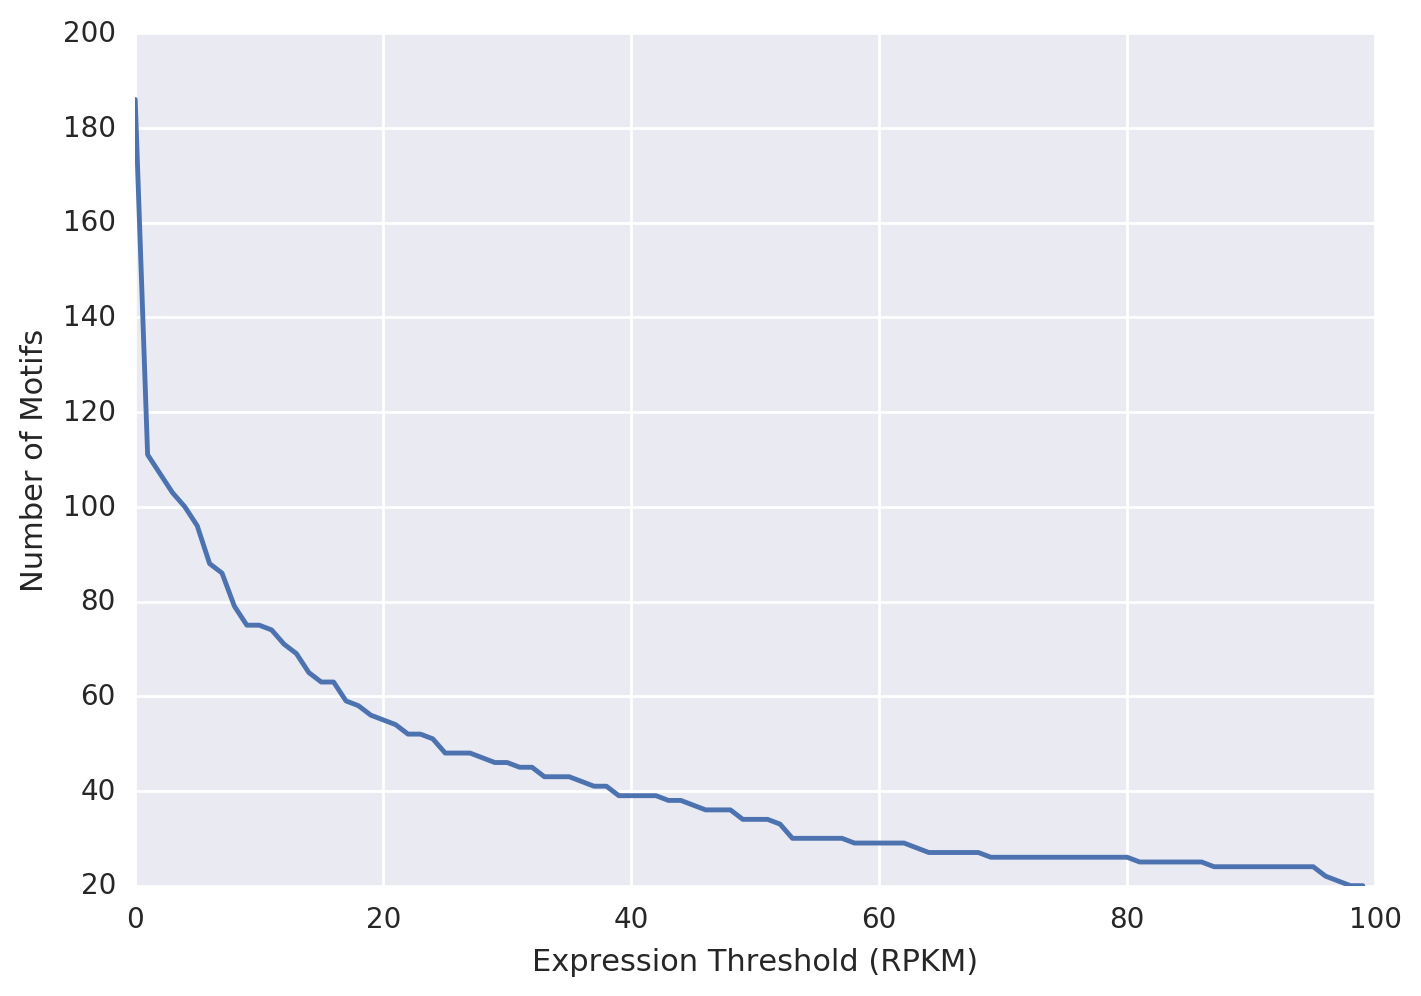

In [32]:
expression_threshold = 16
# thresholds = [1,2,4,8,16,32,64,128]
thresholds = range(100)
num_motifs = []
for expression_threshold in thresholds:
    motifs_at_threshold = []
    gene_names = rpkm_mean_frame[
        rpkm_mean_frame.iloc[:,2:].max(axis=1) >= expression_threshold
                    ].loc[:,'All Gene Names'].values
    for gn in gene_names:
        genes = gn.upper().split('|')
        for g in genes:
            if g in gene_motif_dict:
                motifs_at_threshold += gene_motif_dict[g]
    motifs_at_threshold = sorted(set(motifs_at_threshold))
    num_motifs.append(len(motifs_at_threshold))
plt.plot(thresholds, num_motifs) 
plt.xlabel('Expression Threshold (RPKM)')
plt.ylabel('Number of Motifs')

In [33]:
expression_threshold = 16
motifs_to_include = []
gene_names = rpkm_mean_frame[
    rpkm_mean_frame.iloc[:,2:].max(axis=1) >= expression_threshold
                ].loc[:,'All Gene Names'].values
for gn in gene_names:
    genes = gn.upper().split('|')
    for g in genes:
        if g in gene_motif_dict:
            motifs_to_include += gene_motif_dict[g]
motifs_to_include = sorted(set(motifs_to_include))
print(len(set(motifs_to_include)))

63


In [209]:
for m in motifs_to_include:
    print(m)

ATF4
Ahr::Arnt
Bcl6
CEBP-related_1_merged
CEBP-related_2_merged
CENPB
CREB-related_1_merged
CTCF
Ddit3::Cebpa
E2F-related_1_merged
EGR1
Ets-related_1_merged
Ets-related_2_merged
Forkhead_1_merged
HD-CUT_1_merged
HSF_1_merged
Hairy-related_1_merged
IRF1
IRF2
Interferon-regulatory_1_merged
Jun-related_1_merged
Jun-related_2_merged
MAFG
MAFG::NFE2L1
Maf-related_1_merged
More_1_merged
More_3_merged
NF-kappaB-related_1_merged
NF-kappaB-related_2_merged
NFIL3
NFYA
NRF1
Nfe2l2
Nr1h3::Rxra
Nuclear_1_merged
PAS_1_merged
POU_2_merged
PPARG
PRDM1
Paired-related_3_merged
RREB1
RUNX1
RXR-related_1_merged
RXR-related_3_merged
Regulators_1_merged
SMAD2::SMAD3::SMAD4
SRF
STAT1::STAT2
STAT_1_merged
Steroid_2_merged
Steroid_3_merged
TALE-type_1_merged
TBrain-related_1_merged
TP53
Three-zinc_1_merged
Three-zinc_2_merged
Three-zinc_3_merged
XBP1
YY1
ZBTB7A
ZNF740
bHLH-ZIP_1_merged
p53-related_1_merged


In [ ]:
***NEED TO IMPLEMENT***

In [221]:
sorted(tba_motifs)

['CENPB',
 'CTCF',
 'Creb5',
 'EGR2',
 'HINFP',
 'IRF1',
 'MAFG',
 'Myb',
 'NFYA',
 'NRF1',
 'Nr2e1',
 'PAX5',
 'Pax2',
 'RUNX1',
 'SP1',
 'SP4',
 'SPIB',
 'TFCP2',
 'THAP1',
 'Tcfl5',
 'ZNF143',
 'ap-1',
 'cebpb_cebpd_cebpe_cebpg_merged',
 'ehf_elf1_elf4_elf5_elk3_etv6_merged',
 'elk1_elk3_elk4_erf_erg_ets1_etv1_etv2_etv3_etv4_etv5_etv6_fev_fli1_merged',
 'irf7_irf8_irf9_merged',
 'mef2a_mef2b_mef2d_merged',
 'rel_rela_merged',
 'spi1_spic_merged']

In [25]:
tba_motifs = ['CENPB',
 'CTCF',
 'Creb5',
 'EGR2',
 'HINFP',
 'IRF1',
 'MAFG',
 'Myb',
 'NFYA',
 'NRF1',
 'Nr2e1',
 'PAX5',
 'Pax2',
 'RUNX1',
 'SP1',
 'SP4',
 'SPIB',
 'TFCP2',
 'THAP1',
 'Tcfl5',
 'ZNF143',
 'ap-1',
 'cebpb_cebpd_cebpe_cebpg_merged',
 'ehf_elf1_elf4_elf5_elk3_etv6_merged',
 'elk1_elk3_elk4_erf_erg_ets1_etv1_etv2_etv3_etv4_etv5_etv6_fev_fli1_merged',
 'irf7_irf8_irf9_merged',
 'mef2a_mef2b_mef2d_merged',
 'rel_rela_merged',
 'spi1_spic_merged']

## Create Motif Graphs

In [16]:
def convert_sequences_to_array(sequences):
    '''
    inputs: sequence of nucleotides represented as a string composed of A, C, G, T
    outputs: a list of numpy array representations of a sequence with:
             A = [1, 0, 0, 0]
             C = [0, 1, 0, 0]
             G = [0, 0, 1, 0]
             T = [0, 0, 0, 1]
             
    '''
    nucleotide_array_dict = {'A': [1, 0, 0, 0],
                             'C': [0, 1, 0, 0],
                             'G': [0, 0, 1, 0],
                             'T': [0, 0, 0, 1],
                             'N': [0, 0, 0, 0]}
    sequence_array_list = []
    for seq in sequences:
        seq_array = []
        for nuc in seq:
            seq_array.append(nucleotide_array_dict[nuc])
        seq_array = np.array(seq_array)
        sequence_array_list.append(seq_array)
    return sequence_array_list





In [20]:
def read_fasta(file_path):
    '''
    reads in a fasta file and returns a list of sequence ids and a list of sequences
    inputs: filepath - path to a fasta file
    outputs: sequence_list - a list of sequences
             id_list - a list of ids
    '''
    with open(file_path) as f:
        data = f.readlines()
    id_list = []
    sequence_list = []
    # loop through each sequence
    for line in data:
        if '>' in line:
            seq_id = line.strip()[1:]
            id_list.append(seq_id)
        else:
            seq = line.strip()
            sequence_list.append(seq)
    return sequence_list, id_list




In [21]:
fasta_path = './merged_atac_peaks_filtered_resized.fasta'

sequence_list, id_list = read_fasta(fasta_path)

# convert strings to arrays
sequence_array_list = convert_sequences_to_array(sequence_list)

### Calculate Motif Scores

In [224]:
%%bash
# extract sequences for analysis
pos2bed.pl ./merged_atac_peaks_filtered_resized.tsv > ./tmp
tail -n +2 ./tmp > ./merged_atac_peaks_filtered_resized.bed
rm tmp


	Converted 50181 peaks total



In [225]:
!/gpfs/data01/glasslab/home/jtao/code/tba/model_training/extract_sequences.py ./merged_atac_peaks_filtered_resized.bed mm10 ./merged_atac_peaks_filtered_resized.fasta

reading genome mm10


In [226]:
!rm -r ./motif_scores
!/gpfs/data01/glasslab/home/jtao/code/tba/model_training/calculate_all_motif_scores.py -num_procs 42 ./merged_atac_peaks_filtered_resized.fasta ./motif_scores ./motifs_to_use/*

rm: cannot remove ‘./motif_scores’: No such file or directory
Jun-related_1_merged calculation time: 7.380855083465576
Pax2 calculation time: 6.888531446456909
SPIB calculation time: 7.592357873916626
Nr2e1 calculation time: 8.804948568344116
Myb calculation time: 10.014270305633545
NF-kappaB-related_2_merged calculation time: 10.155832052230835
CEBP-related_2_merged calculation time: 12.319697141647339
CP2-related_1_merged calculation time: 12.702879428863525
RUNX1 calculation time: 10.361478328704834
THAP1 calculation time: 9.865305662155151
HINFP calculation time: 12.665556192398071
NRF1 calculation time: 10.959602117538452
Hairy-related_1_merged calculation time: 12.842435121536255
Ets-related_2_merged calculation time: 13.485893249511719
NF-kappaB-related_1_merged calculation time: 12.763865947723389
Interferon-regulatory_1_merged calculation time: 14.101771116256714
Ets-related_1_merged calculation time: 14.954530954360962
CENPB calculation time: 16.07079529762268
Three-zinc_3_me

### Read Motif Scores

In [15]:
motif_score_dict = {}
motif_score_rc_dict = {}
for f in os.listdir('./motif_scores'):
    motif_name = '_'.join(f.split('_')[:-1])
    if 'rev' in f:
        print('reading', motif_name)
        motif_score_rc_dict[motif_name] = pickle.load(open('./motif_scores/'+f, 'rb'))
    else:
        motif_score_dict[motif_name] = pickle.load(open('./motif_scores/'+f, 'rb'))

reading Three-zinc_1_merged
ERROR! Session/line number was not unique in database. History logging moved to new session 381
reading MAFG
reading CENPB
reading Jun-related_1_merged
reading NRF1
reading CP2-related_1_merged
reading Regulators_1_merged
reading Three-zinc_3_merged
reading Interferon-regulatory_1_merged
reading IRF1
reading Hairy-related_1_merged
reading NF-kappaB-related_2_merged
reading Three-zinc_2_merged
reading SPIB
reading NFYA
reading CEBP-related_2_merged
reading Myb
reading THAP1
reading NF-kappaB-related_1_merged
reading Nr2e1
reading Pax2
reading Ets-related_2_merged
reading RUNX1
reading CTCF
reading Ets-related_1_merged
reading HINFP
reading ZNF143
reading PAX5


### Find Motif Size

In [26]:
motif_size_dict = {}
for f in os.listdir('./motifs_to_use/'):
    m = motifs.read(open('./motifs_to_use/'+f, 'r'), 'jaspar')
    print(f)
    name = f.split('.')[0]
    size = m.length
    motif_size_dict[name] = size

RUNX1.jaspar
HINFP.jaspar
Interferon-regulatory_1_merged.jaspar
NF-kappaB-related_2_merged.jaspar
NRF1.jaspar
Ets-related_2_merged.jaspar
IRF1.jaspar
PAX5.jaspar
THAP1.jaspar
Regulators_1_merged.jaspar
CP2-related_1_merged.jaspar
Pax2.jaspar
Nr2e1.jaspar
CENPB.jaspar
CEBP-related_2_merged.jaspar
SPIB.jaspar
Myb.jaspar
CTCF.jaspar
Hairy-related_1_merged.jaspar
NF-kappaB-related_1_merged.jaspar
MAFG.jaspar
Three-zinc_3_merged.jaspar
Jun-related_1_merged.jaspar
ZNF143.jaspar
Three-zinc_1_merged.jaspar
NFYA.jaspar
Ets-related_1_merged.jaspar
Three-zinc_2_merged.jaspar


### Identify Symmetric Motifs

In [27]:
num_sequence_to_sample = 100
num_seqs = len(sequence_array_list)
mean_pearsons = []
motif_symmetryPearson_dict = {}
for motif in sorted(motif_score_dict.keys()):
    
    pearsons = []
    for i in range(num_sequence_to_sample):
        index = np.random.randint(0,num_seqs)

        forward_scores = motif_score_dict[motif][index]
        reverse_scores = motif_score_rc_dict[motif][index]

        pearson, pval = scipy.stats.pearsonr(forward_scores, reverse_scores)
        pearsons.append(pearson)
    mean_pearson = np.mean(pearsons)
    mean_pearsons.append(mean_pearson)
    motif_symmetryPearson_dict[motif] = mean_pearson
symmetric_motifs = [x for x in motif_symmetryPearson_dict if motif_symmetryPearson_dict[x] > 0.8]



### Refactor motif_score_dict

In [34]:
id_motifScore_forward_dict = {}
for i in range(len(id_list)):
    current_id = id_list[i]
    current_dict = {}
    for motif in motifs_to_include:
        if motif in motif_score_dict:
            current_dict[motif] = motif_score_dict[motif][i]
    id_motifScore_forward_dict[current_id] = current_dict

In [35]:
id_motifScore_reverse_dict = {}
for i in range(len(id_list)):
    current_id = id_list[i]
    current_dict = {}
    for motif in motifs_to_include:
        if motif in motif_score_rc_dict:
            current_dict[motif] = motif_score_rc_dict[motif][i]
    id_motifScore_reverse_dict[current_id] = current_dict

    

In [36]:
def calc_multi_motif_sequence(seq_array, 
                              forward_score_dict, 
                              reverse_score_dict, 
                              motif_size_dict,
                              score_threshold = 0,
                              distance_threshold = 200,
                              symmetric_motifs = [],
                              orientation=False
                             ):
    '''
    '''
    motif_names = sorted(forward_score_dict.keys())
    seq_size = seq_array.shape[0]
    # initialize position_node array
    position_node_array = [[] for x in range(seq_size)]

    # intialize graph
    seq_graph = nx.DiGraph()

    # initialize
    for motif in motif_names:
        motif_size = motif_size_dict[motif]
        indices = list(range(len(forward_score_dict[motif])))
        forward_scores = forward_score_dict[motif]
        revcomp_scores = reverse_score_dict[motif]

        # identify motif instances using score score_threshold
        filtered_forward_motif_instances = [x for x in zip(indices, forward_scores) if x[1]>score_threshold]
        filtered_revcomp_motif_instances = [x for x in zip(indices, revcomp_scores) if x[1]>score_threshold]

        # create graph node for every forward motif instance
        for mi in filtered_forward_motif_instances:
            if motif in symmetric_motifs:
                o = '|'
            elif orientation:
                o = '+'
            else:
                o= '|'
            
            node_id = str(mi[0]) + ' ' + motif + ' '+o
            seq_graph.add_node(node_id, 
                               name=motif,
                               start=mi[0], 
                               end = mi[0] + motif_size, 
                               score=mi[1], 
                               orientation=o)

            # figure out positions motif instance occupies
            start_position = mi[0]
            end_position=start_position + motif_size

            # add node_id to position_node array
            for pos in range(start_position, end_position):
                position_node_array[pos].append(node_id)

        # create graph node for every revcomp motif instance
        for mi in filtered_revcomp_motif_instances:
            if motif in symmetric_motifs:
                o = '|'
            elif orientation:
                o = '-'
            else:
                o= '|'
            node_id = str(mi[0]) + ' ' + motif + ' '+o
            seq_graph.add_node(node_id, 
                               name=motif,
                               start=mi[0], 
                               end = mi[0] + motif_size, 
                               score=mi[1], 
                               orientation=o)

            # figure out positions motif instance occupies
            start_position = mi[0]
            end_position=start_position + motif_size

            # add node_id to position_node array
            for pos in range(start_position, end_position):
                position_node_array[pos].append(node_id)

    # add edges
    all_nodes = seq_graph.nodes(data=True)
    edges_to_add = []
    for node in all_nodes:
        # find the first nonoverlapping motif(s)
        end_pos = node[1]['end']
        first_neighbor_pos = end_pos
        candidate_neighbors = []
        while len(candidate_neighbors) < 1 and first_neighbor_pos < seq_size:
            candidate_neighbors = position_node_array[first_neighbor_pos]
            first_neighbor_pos += 1
            
        # find largest motif amongst the first nonoverlapping motif(s)
        max_size_end = -1
        max_size_start = -1
        for n in candidate_neighbors:
            neighbor = seq_graph.node[n]
            neighbor_end = neighbor['end']
            neighbor_start = neighbor['start']
            if neighbor_end > max_size_end:
                max_size_end = neighbor_end
                max_size_start = neighbor_start
        # identify all motifs that overlap with the first largest nonoverlapping motif(s)
        for pos in range(max_size_start, max_size_end):
            candidate_neighbors = candidate_neighbors + position_node_array[pos]
        candidate_neighbors = set(candidate_neighbors)
        
        for n in candidate_neighbors:
            neighbor = seq_graph.node[n]
            neighbor_start = neighbor['start']
            if neighbor_start >= end_pos:
                edges_to_add.append((node[0], n))
    seq_graph.add_edges_from(edges_to_add)

    # creat start node and connect all nodes with 0 incoming edges
    start_edges = []
    for node_id, in_degree in seq_graph.in_degree_iter():
        if in_degree == 0:
            start_edges.append(('start', node_id))
            
    # create end node and connect all nodes with 0 outgoing edges
    end_edges = []
    for node_id, out_degree in seq_graph.out_degree_iter():
        if out_degree == 0:
            end_edges.append((node_id, 'end'))
    
    if len(start_edges) > 0:
        seq_graph.add_edges_from(start_edges)
    else:
        seq_graph.add_node('start')
    if len(end_edges) > 0:
        seq_graph.add_edges_from(end_edges)
    else:
        seq_graph.add_node('end')
    # generate all paths from start to end node
    paths = nx.all_simple_paths(seq_graph, 'start', 'end')
    
    # add data to list of paths
    id_score_dict = nx.get_node_attributes(seq_graph, 'score')
    paths_with_data = []
    paths_without_data = []
    counter = 0
    for p in paths:
        
        if counter > 1000:
            print('Too many paths!!!')
            return seq_graph, [], [] 
        counter += 1
        
        current_p_with_data = []
        current_p_without_data = []
        for n in p:
            # exclude end and start nodes which were created just for creating paths
            if not n== 'start' and not n == 'end':
                tokens = n.split()
                motif_name = tokens[1]
                orientation = tokens[2]
                score = id_score_dict[n]
                
                n_with_data = (motif_name, orientation, score)
                current_p_with_data.append(n_with_data)
                if orientation:
                    current_p_without_data.append(motif_name + ' ' + orientation)
                else:
                    current_p_without_data.append(motif_name)
        paths_with_data.append(current_p_with_data)
        paths_without_data.append(current_p_without_data)

    return seq_graph, paths_with_data, paths_without_data

In [37]:
index = 100
seq_array = sequence_array_list[index]
forward_score_dict = id_motifScore_forward_dict[id_list[index]]
reverse_score_dict = id_motifScore_reverse_dict[id_list[index]]
graph, paths, paths_nodata = calc_multi_motif_sequence(seq_array, 
                              forward_score_dict, 
                              reverse_score_dict, 
                              motif_size_dict,
                              score_threshold = 5,
                              distance_threshold = 200,
                              symmetric_motifs = symmetric_motifs,
                              orientation = True
                             )
print(nx.info(graph))


Name: 
Type: DiGraph
Number of nodes: 15
Number of edges: 20
Average in degree:   1.3333
Average out degree:   1.3333


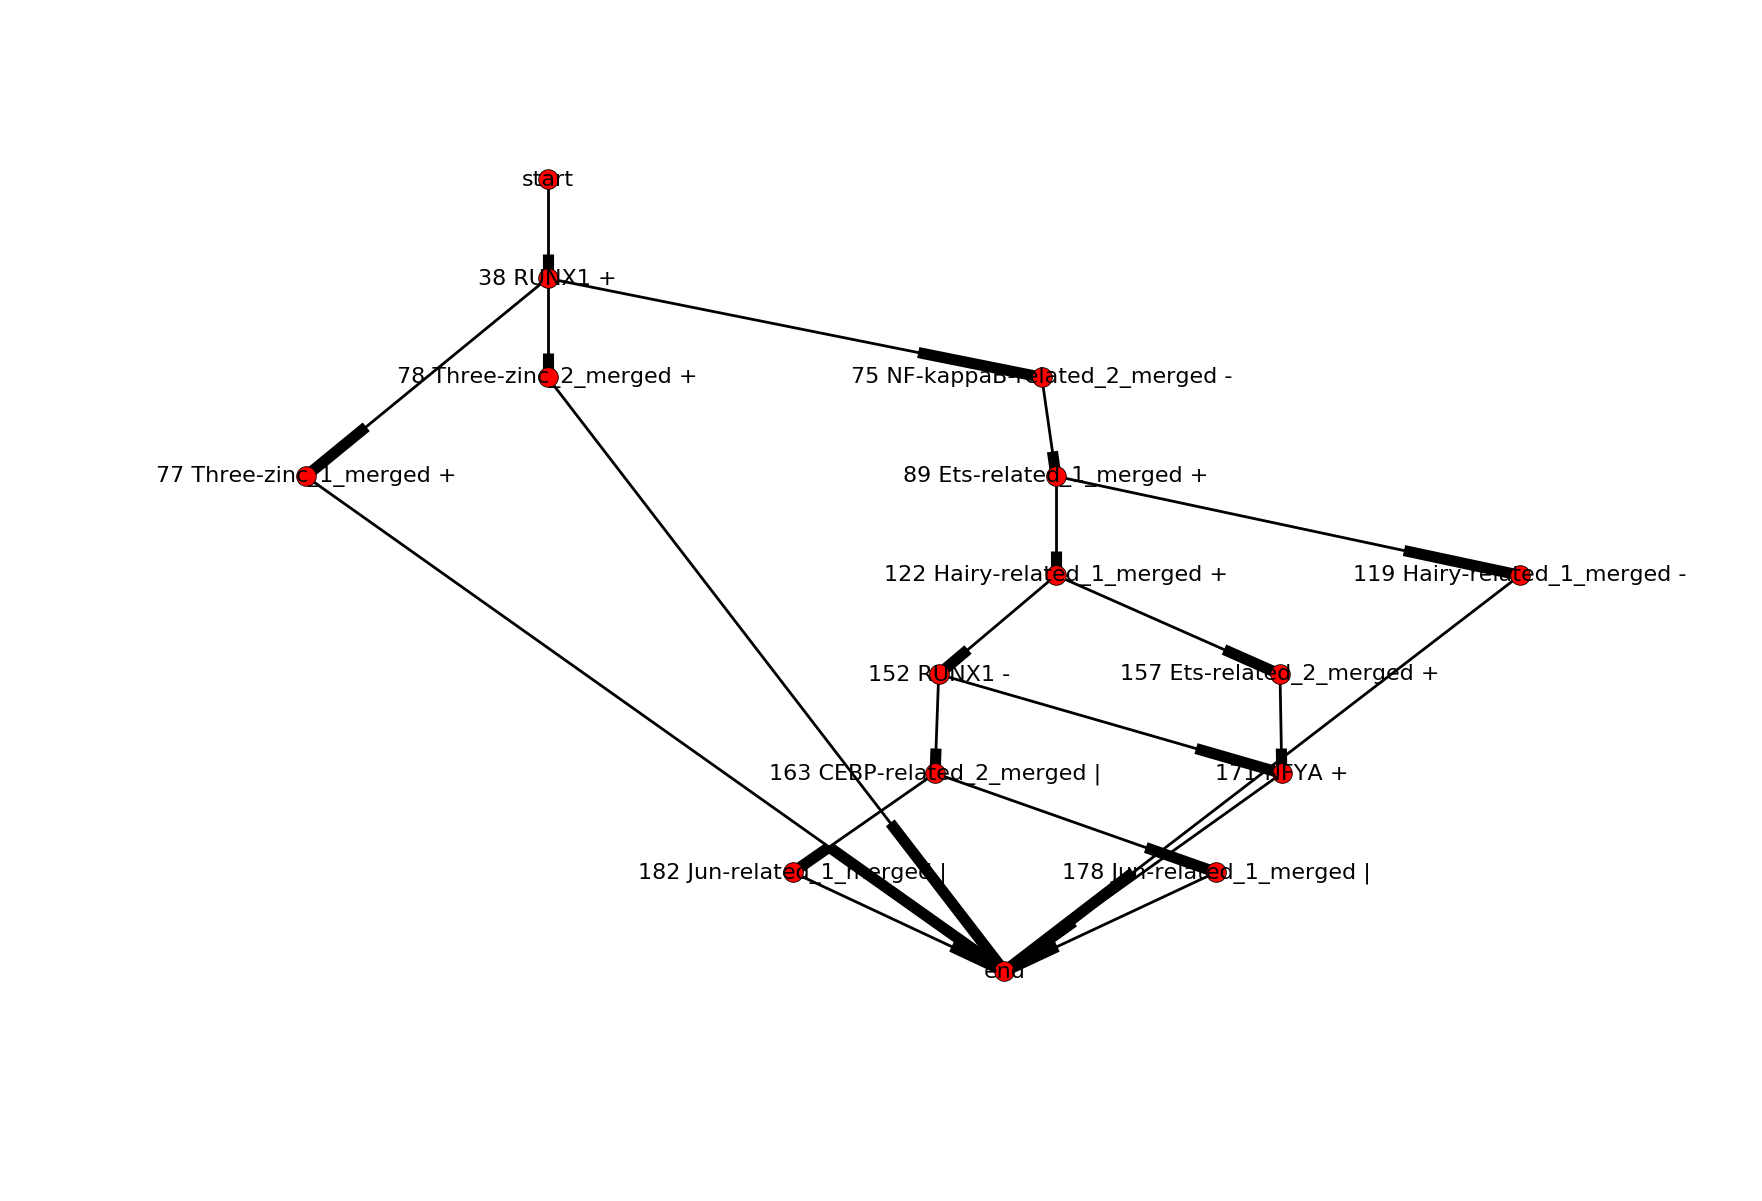

In [38]:
nx.draw(graph,
        node_size=50,
        with_labels=True,
        font_size = 8,
        pos=graphviz_layout(graph, prog = 'dot'))


## Create Graphs

### No Orientation

In [39]:
id_pathList_dict_noOrientation = {}
id_graph_dict_noOrientation = {}
counter = 0
for index in range(len(id_list)):
    if index % 100 ==0: 
        print(index)
    seq_id = id_list[index]
    if seq_id in differential_enhancer_frame.index:
        seq_array = sequence_array_list[index]
        forward_score_dict = id_motifScore_forward_dict[seq_id]
        reverse_score_dict = id_motifScore_reverse_dict[seq_id]
        result = calc_multi_motif_sequence(seq_array, 
                 forward_score_dict, 
                 reverse_score_dict, 
                 motif_size_dict,
                 score_threshold = 5,
                 distance_threshold = 200,
                 symmetric_motifs = symmetric_motifs,
                 orientation = False
                 )
        graph, paths_with_data, paths_without_data = result
        if len(paths_without_data) > 1:
            id_pathList_dict_noOrientation[seq_id] = paths_without_data
            id_graph_dict_noOrientation[seq_id] = graph
        else:
            counter +=1
print(counter)

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000
10100
10200
10300
10400
10500
10600
10700
10800
10900
11000
11100
11200
11300
11400
11500
11600
11700
11800
11900
12000
12100
12200
12300
12400
12500
12600
12700
12800
12900
13000
13100
13200
13300
13400
13500
13600
13700
13800
13900
14000
14100
14200
14300
14400
14500
14600
14700
14800
14900
15000
15100
15200
15300
15400
15500
15600
15700
15800
15900
16000
16100
16200
16300
16400
16500
16600
16700
16800
16900
17000
17100
17200
17300
17400
17500
17600
17700
17800
17900
18000
18100
18200
18300
18400
18

### Oriented

In [40]:
id_pathList_dict = {}
id_graph_dict = {}
counter = 0
for index in range(len(id_list)):
    if index % 100 ==0: 
        print(index)
    seq_id = id_list[index]
    if seq_id in differential_enhancer_frame.index:
        seq_array = sequence_array_list[index]
        forward_score_dict = id_motifScore_forward_dict[seq_id]
        reverse_score_dict = id_motifScore_reverse_dict[seq_id]
        result = calc_multi_motif_sequence(seq_array, 
                 forward_score_dict, 
                 reverse_score_dict, 
                 motif_size_dict,
                 score_threshold = 5,
                 distance_threshold = 200,
                 symmetric_motifs = symmetric_motifs,
                 orientation = True
                 )
        graph, paths_with_data, paths_without_data = result
        if len(paths_without_data) > 1:
            id_pathList_dict[seq_id] = paths_without_data
            id_graph_dict[seq_id] = graph
        else:
            counter +=1
print(counter)

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000
10100
10200
10300
10400
10500
10600
10700
10800
10900
11000
11100
11200
11300
11400
11500
11600
11700
11800
11900
12000
12100
12200
12300
12400
12500
12600
12700
12800
12900
13000
13100
13200
13300
13400
13500
13600
13700
13800
13900
14000
14100
14200
14300
14400
14500
14600
14700
14800
14900
15000
15100
15200
15300
15400
15500
15600
15700
15800
15900
16000
16100
16200
16300
16400
16500
16600
16700
16800
16900
17000
17100
17200
17300
17400
17500
17600
17700
17800
17900
18000
18100
18200
18300
18400
18

## Graph Stats

23.3900408879


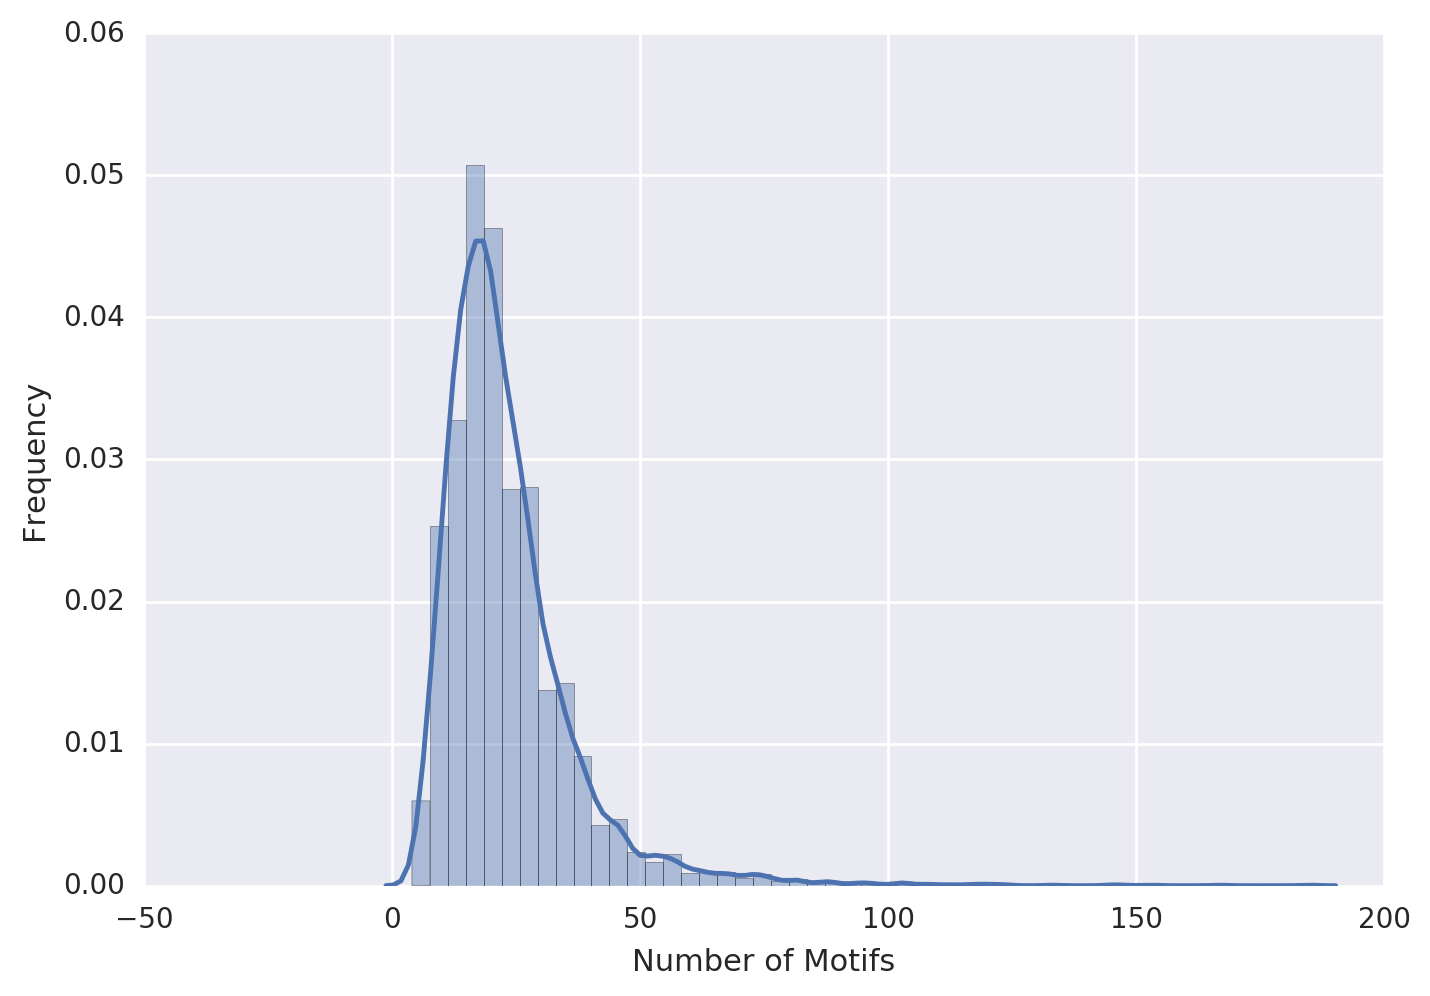

In [429]:
sizes = []

for i in id_graph_dict.keys():
    g = id_graph_dict[i]
    sizes.append(g.size())
sns.distplot(sizes)
plt.ylabel('Frequency')
plt.xlabel('Number of Motifs')
print(np.mean(sizes))

1.0


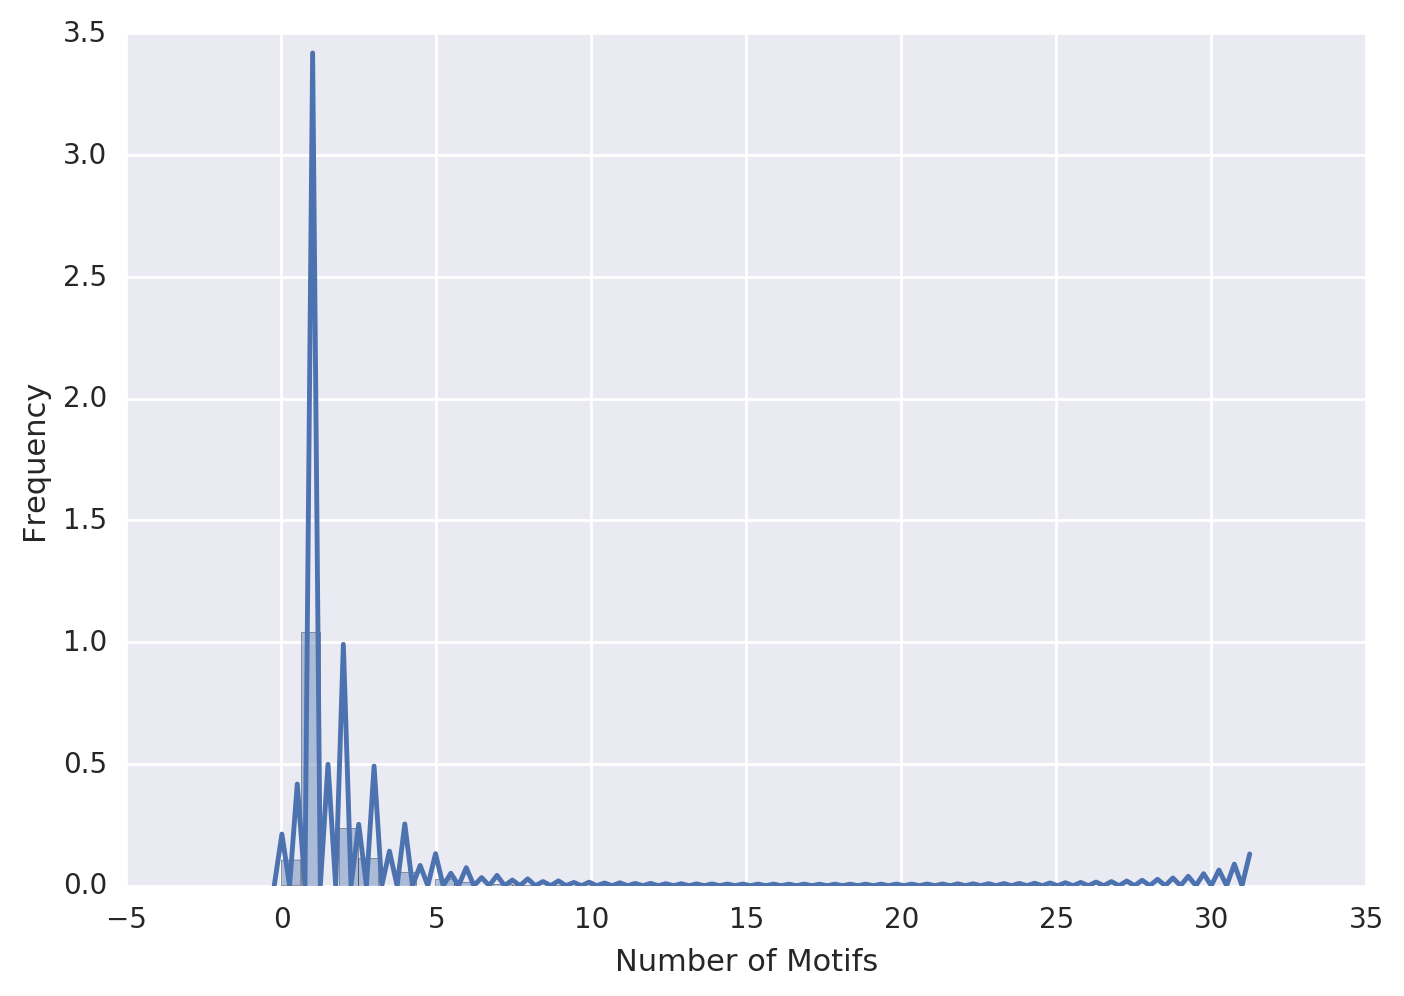

In [435]:
degrees = []

for i in id_graph_dict.keys():
    g = id_graph_dict[i]
    d = g.out_degree()
    for k in d.keys():
        degrees.append(d[k])
sns.distplot(degrees)
plt.ylabel('Frequency')
plt.xlabel('Number of Motifs')
print(np.median(degrees))

5.18148424919


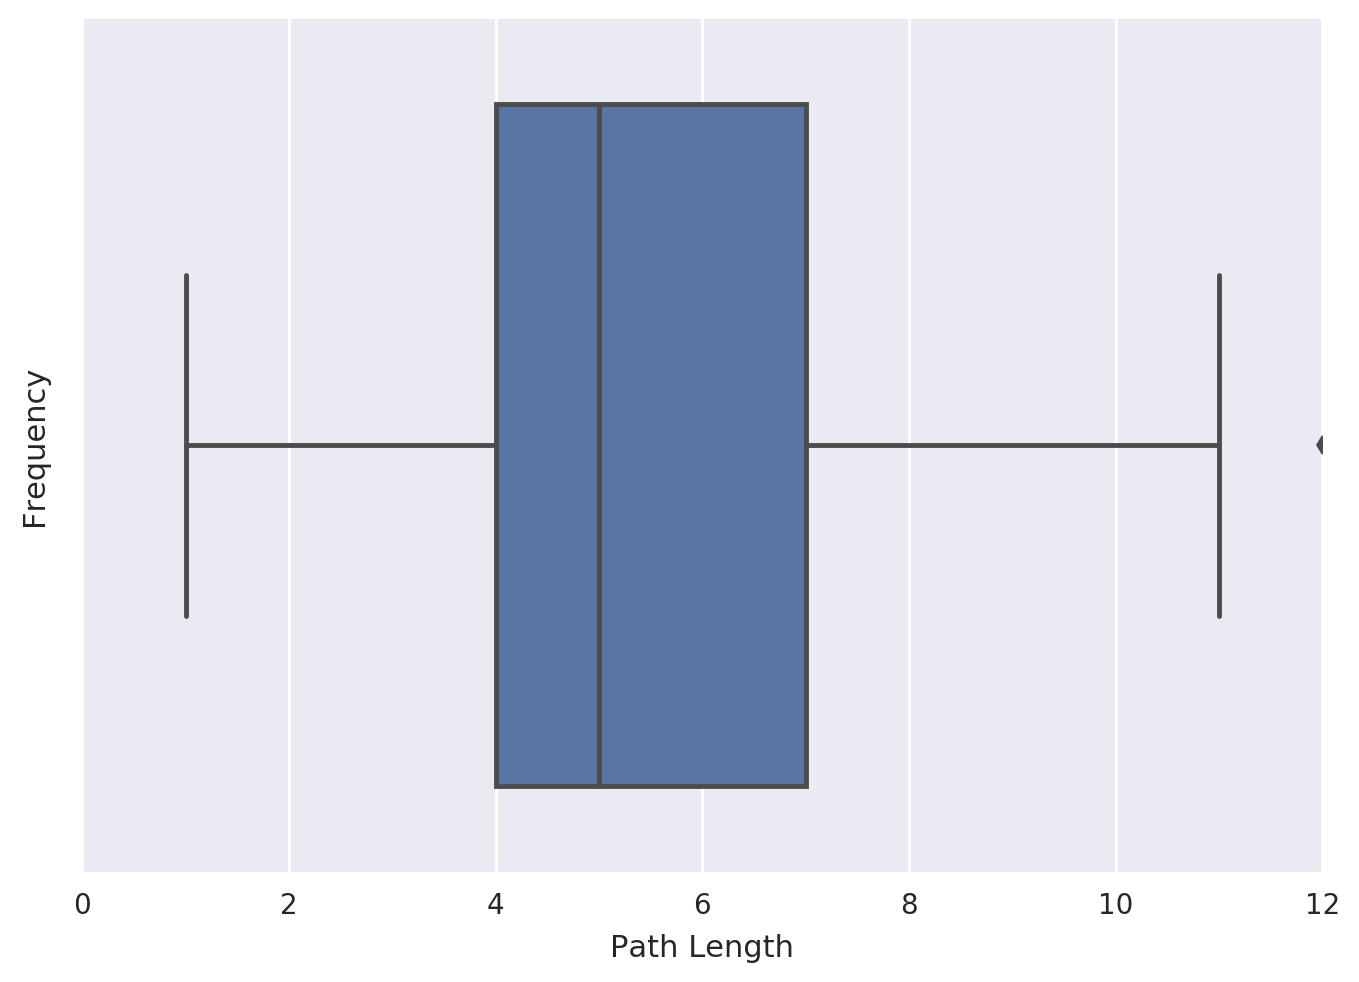

In [422]:
lengths = []

for i in id_graph_dict.keys():
    paths = id_pathList_dict[i]
    for p in paths:
        lengths.append((len(p)))
sns.boxplot(lengths)
plt.ylabel('Frequency')
plt.xlabel('Path Length')
print(np.mean(lengths))

## Find Patterns

### Prefix Span

In [41]:
min_support_level = 50

frequent_oriented_patterns = motif_prefix_span([], id_pathList_dict, min_support_level)
frequent_unoriented_patterns = motif_prefix_span([], id_pathList_dict_noOrientation, min_support_level)




In [42]:
pickle.dump(frequent_oriented_patterns, open('./frequent_oriented_patterns.pickle','wb'))
pickle.dump(frequent_unoriented_patterns, open('./frequent_unoriented_patterns.pickle','wb'))

In [43]:
sequence_pattern_oriented_table = create_pattern_sequence_table(frequent_oriented_patterns, id_pathList_dict)

done searching for RUNX1 + * RUNX1 + * RUNX1 - 1.165571928024292
done searching for RUNX1 + * RUNX1 + * NF-kappaB-related_2_merged - 2.475959300994873
done searching for RUNX1 + * RUNX1 - * Ets-related_2_merged + 2.3424789905548096
done searching for RUNX1 + * RUNX1 + * Ets-related_2_merged + 2.8582451343536377
done searching for RUNX1 + * RUNX1 + * Three-zinc_2_merged - 3.130629062652588
done searching for RUNX1 + * RUNX1 + * Three-zinc_2_merged + 3.3201465606689453
done searching for RUNX1 + * RUNX1 + * Ets-related_1_merged + 2.9131383895874023
done searching for RUNX1 + * RUNX1 - * Three-zinc_2_merged + 2.907738447189331
done searching for RUNX1 + * RUNX1 + * Jun-related_1_merged | 3.5088770389556885
done searching for RUNX1 + * RUNX1 - * RUNX1 + 2.9632010459899902
done searching for RUNX1 + * RUNX1 - * Ets-related_1_merged - 3.0396876335144043
done searching for RUNX1 + * RUNX1 - * Three-zinc_1_merged + 3.033203363418579
done searching for RUNX1 + * RUNX1 + * Ets-related_1_merged -

In [44]:
sequence_pattern_oriented_table.to_pickle('./sequence_pattern_oriented_table.pickle')

In [45]:
sequence_pattern_unoriented_table = create_pattern_sequence_table(frequent_unoriented_patterns, id_pathList_dict)
sequence_pattern_unoriented_table.to_pickle('./sequence_pattern_unoriented_table.pickle')

done searching for RUNX1 | * RUNX1 | * RUNX1 | * Hairy-related_1_merged | 1.6697373390197754
done searching for RUNX1 | * RUNX1 | * RUNX1 | * Ets-related_2_merged | 2.574108839035034
done searching for RUNX1 | * RUNX1 | * Three-zinc_2_merged | 2.392878770828247
done searching for RUNX1 | * RUNX1 | * RUNX1 | * IRF1 | 3.0555484294891357
done searching for RUNX1 | * RUNX1 | * RUNX1 | 3.14875864982605
done searching for RUNX1 | * RUNX1 | * RUNX1 | * Three-zinc_1_merged | 3.4270131587982178
done searching for RUNX1 | * RUNX1 | * Three-zinc_2_merged | * Ets-related_2_merged | 3.332796573638916
done searching for RUNX1 | * RUNX1 | * Three-zinc_2_merged | * NF-kappaB-related_2_merged | 3.8070640563964844
done searching for RUNX1 | * RUNX1 | * RUNX1 | * CEBP-related_2_merged | 3.94233775138855
done searching for RUNX1 | * RUNX1 | * Three-zinc_2_merged | * Three-zinc_1_merged | 3.891489267349243
done searching for RUNX1 | * RUNX1 | * Ets-related_2_merged | * NF-kappaB-related_2_merged | 2.726345

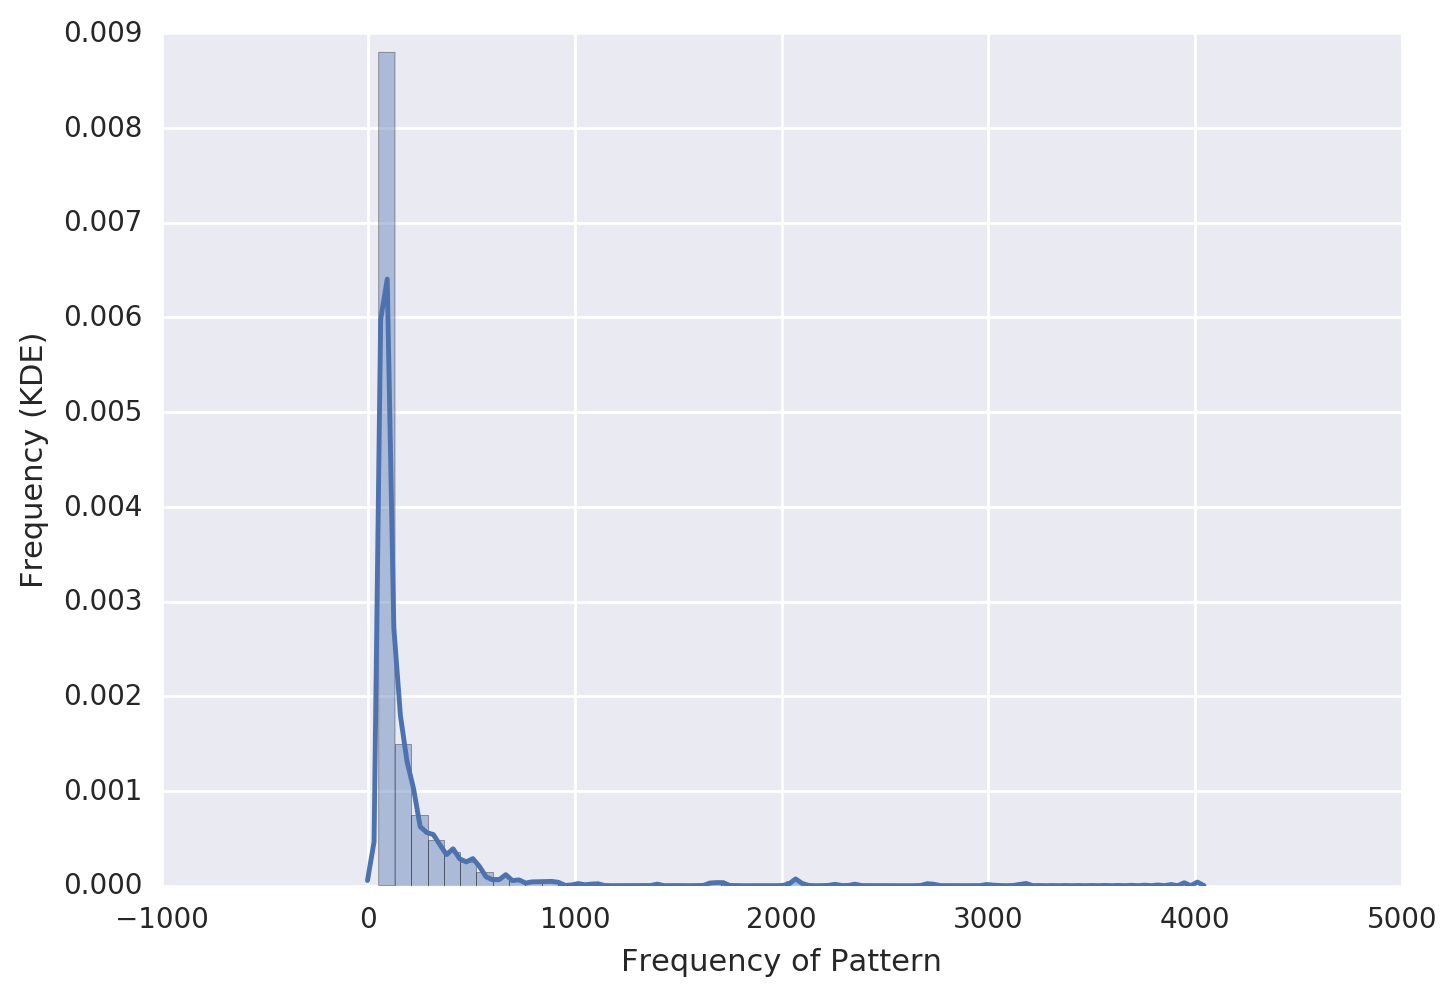

In [47]:
sns.distplot(sequence_pattern_oriented_table.sum())
plt.xlabel('Frequency of Pattern')
plt.ylabel('Frequency (KDE)')

In [50]:
enhancerID_cluster_dict = dict(zip(differential_enhancer_frame.index.values,
                                   differential_enhancer_frame['cluster'].values))

In [52]:
from sklearn import tree

### Oriented

## Train Decision Tree

### Oriented

In [68]:
num_iters = 20
performance_oriented_list = []
clf = tree.DecisionTreeClassifier(criterion='gini',
                                  max_depth=5, 
                                 min_samples_split=10,
                                 min_samples_leaf=10,
                                 )
labels = pd.Series([enhancerID_cluster_dict[x] for x in sequence_pattern_oriented_table.index.values],
                   index= sequence_pattern_oriented_table.index.values)

for i in range(num_iters):
    training_features, test_features, training_labels, test_labels = get_split(sequence_pattern_oriented_table,
                                                                               labels, test_size=0.2)
    clf.fit(training_features, 
            training_labels
            )
    # print(clf.predict_proba(test_features, test_labels))
    test_performance = clf.score(test_features, test_labels)
    training_performance = clf.score(training_features, training_labels)
    print(test_performance, training_performance)
    performance_oriented_list.append(test_performance)

0.447136563877 0.439683707245
0.410425844347 0.441706509746
0.412628487518 0.444280985656
0.407488986784 0.440603162928
0.42657856094 0.436557557926
0.428781204112 0.439315924972
0.412628487518 0.445016550202
0.408957415565 0.42442074292
0.432452276065 0.437109231335
0.428046989721 0.436925340199
0.419236417034 0.440419271791
0.413362701909 0.441890400883
0.423641703377 0.433431408606
0.422907488987 0.441706509746
0.40234948605 0.440787054064
0.408957415565 0.440603162928
0.425110132159 0.43324751747
0.422173274596 0.440419271791
0.395741556535 0.445384332475
0.424375917768 0.428650239058


In [70]:
tree.export_graphviz(clf, 
                     out_file='tree_oriented.dot',
                     feature_names = sequence_pattern_oriented_table.columns.values)

!dot -Tpng tree_oriented.dot -o tree_oriented.png

In [56]:
num_iters = 20
performance_unoriented_list = []
clf = tree.DecisionTreeClassifier(criterion='gini',
                                  max_depth=5, 
                                 min_samples_split=10,
                                 min_samples_leaf=10,
                                 )
labels = pd.Series([enhancerID_cluster_dict[x] for x in sequence_pattern_unoriented_table.index.values],
                   index= sequence_pattern_oriented_table.index.values)

for i in range(num_iters):
    training_features, test_features, training_labels, test_labels = get_split(sequence_pattern_unoriented_table,
                                                                               labels, test_size=0.2)
    clf.fit(training_features, 
            training_labels
            )
    # print(clf.predict_proba(test_features, test_labels))
    test_performance = clf.score(test_features, test_labels)
    training_performance = clf.score(training_features, training_labels)
    print(test_performance, training_performance)
    performance_unoriented_list.append(test_performance)

ERROR! Session/line number was not unique in database. History logging moved to new session 399
0.354625550661 0.374954027216
0.357562408223 0.374402353807
0.362701908957 0.372011769033
0.36637298091 0.372563442442
0.380323054332 0.368150055167
0.36563876652 0.372563442442
0.355359765051 0.373850680397
0.354625550661 0.374586244943
0.357562408223 0.374586244943
0.380323054332 0.36851783744
0.372980910426 0.369437293122
0.350220264317 0.374402353807
0.361967694567 0.373299006988
0.372246696035 0.370540639941
0.367107195301 0.370172857668
0.375183553598 0.370724531078
0.376651982379 0.368885619713
0.357562408223 0.374586244943
0.356828193833 0.373666789261
0.370044052863 0.37164398676


In [63]:
2260/len(row_flatCluster)

0.3264480716452405

In [62]:
Counter(row_flatCluster)

Counter({1: 292, 2: 976, 3: 741, 4: 2260, 5: 410, 6: 237, 7: 2007})

/home/jtao/software/anaconda3/lib/python3.5/site-packages/seaborn-0.7.1-py3.5.egg/seaborn/categorical.py:2171: UserWarning: The boxplot API has been changed. Attempting to adjust your arguments for the new API (which might not work). Please update your code. See the version 0.6 release notes for more info.
  warnings.warn(msg, UserWarning)


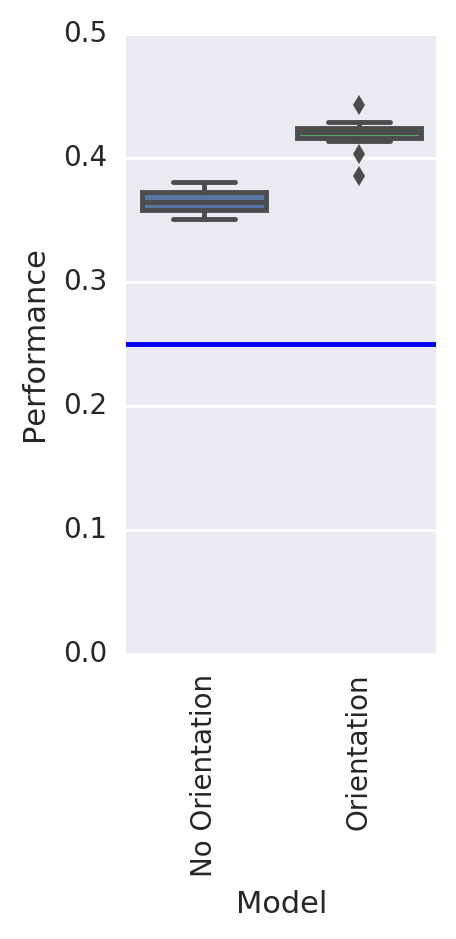

In [67]:
plt.figure(figsize=(2,4))
sns.boxplot(pd.DataFrame({'Orientation':performance_oriented_list,
                          'No Orientation':performance_unoriented_list,
                          }
                        ))
plt.xticks(rotation=90)
plt.ylabel('Performance')
plt.xlabel('Model')
plt.ylim(0,0.5)
plt.axhline(y=0.25,xmin=0, xmax=2)

